In [ ]:
# Use predictors_simple kernel

# This notebook contains all the code used to explore/interpret many trained models in parallel
# Author: Claire LeBlanc
# Modified: 9/9/25

import numpy as np
import pandas as pd
import tensorflow as tf # tested on version 2.2.0
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['font.sans-serif'] = 'Arial'
from matplotlib import pyplot as plt
from joblib import load
from scipy.stats import spearmanr
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import auc
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import seaborn as sns
import re

import os

os.chdir("../../Model")
from ADModel_three_state import ADModel_three_state_abund
from ADModel_two_state import ADModel_two_state_abund 
from ADModel_act import ADModel_act
from ADModel_abund import ADModel_abund
from Data import DataReader, SplitData, FastTensorDataLoader

os.chdir("..")

In [2]:
import matplotlib 
# For higher resoltion figures
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Helvetica" #somethings this one doesnt work
plt.rcParams['pdf.fonttype'] = 42

# Load the Data

In [3]:
# For three state model:
# This is an attempt to choose the "best" model in an unbiased way
# Specifically, it tries to choose a model that has both a high pearson and a high spearman correlation
# It does this by choosing the model with the highest combined spearman and pearson rank

data_three_state = pd.read_csv("results/results_three_state_abund_test_larger_LR.csv")

data_three_state["abund_kernel_size"] = [re.search("ak(\d+)", s).group(1) for s in data_three_state['model_name']]
data_three_state = data_three_state.sort_values("pearson_act_val", ascending=False)
data_three_state = data_three_state.reset_index()
data_three_state["r1"] = data_three_state.index

data_three_state = data_three_state.sort_values("spearman_act_val", ascending=False)
data_three_state = data_three_state.reset_index()
data_three_state["r2"] = data_three_state.index
data_three_state = data_three_state.drop(columns="level_0")


data_three_state["max_rank"] = data_three_state[["r1","r2"]].max(axis=1)            # min–max rule
data_three_state["sum_rank"] = data_three_state["r1"] + data_three_state["r2"]                  # Borda

data_three_state = data_three_state[data_three_state['activity_fun'] == "Hill"]

In [4]:
# Loading the best two-state model in an unbiased way

# For two state model:
# This is an attempt to choose the "best" model in an unbiased way
# Specifically, it tries to choose a model that has both a high pearson and a high spearman correlation
# It does this by choosing the model with the highest combined spearman and pearson rank

data_two_state = pd.read_csv("results/results_two_state_test_larger_LR.csv")
data_two_state["abund_kernel_size"] = [re.search("ak(\d+)", s).group(1) for s in data_two_state['model_name']]

data_two_state = data_two_state.sort_values("pearson_act_val", ascending=False)
data_two_state = data_two_state.reset_index()
data_two_state["r1"] = data_two_state.index

data_two_state = data_two_state.sort_values("spearman_act_val", ascending=False)
data_two_state = data_two_state.reset_index()
data_two_state["r2"] = data_two_state.index
data_two_state = data_two_state.drop(columns="level_0")


data_two_state["max_rank"] = data_two_state[["r1","r2",]].max(axis=1)            # min–max rule
data_two_state["sum_rank"] = data_two_state["r1"] + data_two_state["r2"]               # Borda

data_two_state = data_two_state[data_two_state['activity_fun'] == "Hill"]

In [5]:
# This is an attempt to choose the "best" model in an unbiased way
# Specifically, it tries to choose a model that has both a high pearson and a high spearman correlation
# It does this by choosing the model with the highest combined spearman and pearson rank

# Calcualte spearman ranks
data_simple_act = pd.read_csv("results/results_simple_act_test_larger_LR.csv")
data_simple_act = data_simple_act.sort_values(" spearman_act_val", ascending=False)
data_simple_act = data_simple_act.reset_index()
data_simple_act["r1"] = data_simple_act.index

# Calculate pearson ranks
data_simple_act = data_simple_act.sort_values(" pearson_act_val", ascending=False)
data_simple_act = data_simple_act.reset_index()
data_simple_act["r2"] = data_simple_act.index
data_simple_act = data_simple_act.drop(columns="level_0")

# Add ranks to get combined rank
data_simple_act["sum_rank"] = data_simple_act["r1"] + data_simple_act["r2"]                    # Borda

In [6]:
# This is an attempt to choose the "best" model in an unbiased way
# Specifically, it tries to choose a model that has both a high pearson and a high spearman correlation
# It does this by choosing the model with the highest combined spearman and pearson rank

# Calcualte spearman ranks
data_simple_abund = pd.read_csv("results/results_simple_abund_test_larger_LR.csv")
data_simple_abund = data_simple_abund.sort_values(" spearman_act_val", ascending=False)
data_simple_abund = data_simple_abund.reset_index()
data_simple_abund["r1"] = data_simple_abund.index

# Calculate pearson ranks
data_simple_abund = data_simple_abund.sort_values(" pearson_act_val", ascending=False)
data_simple_abund = data_simple_abund.reset_index()
data_simple_abund["r2"] = data_simple_abund.index
data_simple_abund = data_simple_abund.drop(columns="level_0")

# Add ranks to get combined rank
data_simple_abund["sum_rank"] = data_simple_abund["r1"] + data_simple_abund["r2"]                    # Borda

# Defining plotting functions

In [7]:
amino_acids = ["R","K","H","D","E","M","I","L","V","A","F","Y","W","Q","N","S","T","G","P","C"]

# Weights preparation
def get_conv_weights(model, layer): 
    """
    Extracts the convolutional weights of the NN 
    and returns a pandas data frame
    """
    model_state_dict = model.state_dict()
    width = model_state_dict[layer].shape[0] * model_state_dict[layer].shape[2]
    conv_weight = model_state_dict[layer].detach().numpy().reshape(width,20)
    conv_weights = pd.DataFrame(conv_weight,columns = ["R","H","K","D","E","S","T","N","Q","C","G","P","A","V","I","L","M","F","Y","W"])
    conv_weights = conv_weights[amino_acids]
    return conv_weights

def get_linear_weights(model, layer):
    """
    Extracts the linear weights to the NN
    and returns a numpy array
    """
    model_state_dict = model.state_dict()
    linear_weights = model_state_dict[layer].detach().numpy()
    return linear_weights


In [8]:
# Defining the colors used in all the figures

colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # Blue, White, Red
n_bins = 100  # Number of color bins
cmap_name = "custom_colormap"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
custom_cmap.set_bad(color='white', alpha=1.0)  # Handle NaN values, if any
colors = {'A': 'purple', 'C': 'darkorange', 'E': 'blue', 'D': 'blue', 'G': 'darkorange', 
                  'F': 'indigo', 'I': 'purple', 'H': 'green', 'K': 'green', 'M': 'purple', 
                  'L': 'purple', 'N': 'darkslategray', 'Q': 'darkslategray', 'P': 'darkorange', 'S': 'darkslategray', 
                  'R': 'green', 'T': 'darkslategray', 'W': 'indigo', 'V': 'purple', 'Y': 'indigo'}

In [9]:
def get_mean_weights(model_list, layer_num=1): 
    """
    Takes a list of models and averages their weights (should all have the same filter size).
    Averages models with positive and negative linear weights separately.

    Parameters 
    ----------
    model_list : list
        list of NNs 

    layer_num : int
        Which layer of the NN we are interested in

    Returns 
    -------
    mean_conv_array : np.array
        Mean of the convolutional weights for the given models
        which had positive linear weights
    mean_linear_array : np.array
        Mean of the linear weights for the given models
        which had poitive linear weights
    mean_conv_array_neg : np.array
        Mean of the convolutional weights for the given models
        which had negative linear weights
    mean_linear_array_neg : np.array
        Mean of the linear weights for the given models
        which had negative linear weights
    """
    conv_weights = []
    linear_weight_ls = []
    conv_array_neg = []
    linear_array_neg = []
    
    # Get the weights for each model
    for model in model_list:
        linear_weights = get_linear_weights(model, f"linear{layer_num}.weight")

        # Separate weights by positive and negative 
        if (linear_weights.sum() < 0):
            conv_array_neg.append(get_conv_weights(model, f"conv{layer_num}.weight").values)
            linear_array_neg.append(linear_weights)
        else: 
            conv_weight = get_conv_weights(model, f"conv{layer_num}.weight").values
            linear_weight_ls.append(linear_weights)
            conv_weights.append(conv_weight)

    # Average convolutional weights
    stacked_arrays = np.stack(conv_weights, axis=0)
    mean_conv_array = np.mean(stacked_arrays, axis=0)

    # Average positive linear weights
    stacked_arrays = np.stack(linear_weight_ls, axis=0)
    mean_linear_array = np.mean(linear_weight_ls, axis=0)

    # Average negative linear weights (if they exist)
    if len(conv_array_neg) > 0:
        stacked_arrays = np.stack(conv_array_neg, axis=0)
        mean_conv_array_neg = np.mean(stacked_arrays, axis=0)
        stacked_arrays = np.stack(linear_array_neg, axis=0)
        mean_linear_array_neg = np.mean(linear_array_neg, axis=0)
    else: 
        mean_conv_array_neg = np.array([])
        mean_linear_array_neg = np.array([])

    return mean_conv_array, mean_linear_array.flatten(), mean_conv_array_neg, mean_linear_array_neg.flatten()

In [10]:
def make_row_plot(fig, kernel_size, model_conv1, model_linear1, row, lim, height_ratios, num_rows, height_max=0, height_min=0):
    """
    Core functionality for creating the convolutional filter plots. 
    Plots the convolution filter as a heatmap and the linear weights as a bar plot.

    Parameters
    ----------
    fig : matplotlib.figure.Figure
        Figure object created with plt.figure
    
    kernel_size : int
        The size of the convolutional filter

    model_conv1 : np.array
        Averaged convolutional filter weights

    model_linear1 : np.array
        Averaged linear filter weights
    
    row : int
        Which row in the overall figure should we fill in

    lim : float
        The max value for the heatmap

    height_ratios : list
        Ratio of heights between rows, length should correspond to number of rows in
        gridspec object

    num_rows : list
        The number of rows in the gridspec object
    
    height_max : float
        The maximum value for the barplot

    height_min : float
        The minimum value for the barplot

    Returns
    -------
    ax1 : maplotlib.Axes object
        Contains the heatmap
    ax2 : maplotlib.Axes object
        Contains the barplot
    im1 : maplotlib.Axes.imshow object
        The heatmap
    """

    # Calculate how much of the figure the convolutional filter vs. linear weights will take up
    ratio1 = kernel_size 
    ratio2 = 40 - kernel_size + 1
    
    # GridSpec allows us to plot rows/columns with different dimensions
    # Here, we initalize the gridspec object with the total number of rows in our figure
    # But we only fill in the specific row that we are interested in
    # (When combined with many other gridspec objects, they will all line up and look good)
    gs1 = gridspec.GridSpec(2 + num_rows*2, 2, width_ratios=[ratio1, ratio2], height_ratios=height_ratios, figure=fig)
    
    # ax1 and ax2 are matplotlib axes
    ax1 = plt.subplot(gs1[row, 0])
    ax2 = plt.subplot(gs1[row, 1])

    # This is the code for plotting the convolutional filter as a heatmap
    # Min and max values of heatmap are passed by used
    im1 = ax1.imshow(model_conv1, cmap=custom_cmap, aspect='auto',vmin=-lim,vmax=lim)
    ax1.set_yticks(range(len(amino_acids)), amino_acids)  # Label x-axis with column names
    ax1.set_xticks(np.arange(kernel_size, step=2))
    
    # This is to color the amino acid labels
    for ytic in ax1.get_yticklabels():
        if ytic.get_text() in colors.keys(): 
            ytic.set_color(colors[ytic.get_text()])
    ax1.tick_params(axis='x', which='major', labelsize=15) 
    ax1.tick_params(axis='y', which='major', labelsize=8) 

    # This is the code for plotting the linear weights as a bar graph
    ax2.bar(range(len(model_linear1)), model_linear1, color="grey")
    ax2.set_ylim(height_min, height_max)
    
    ax2.spines["top"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["bottom"].set_position('zero')
    ax2.spines["bottom"].set_linewidth(2.5)
    ax2.spines['bottom'].set_bounds(-1, len(model_linear1))
    
    # Remove all x-ticks for the bargraph
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])

    return ax1, ax2, im1

def make_multi_filter_plot_mean(models, kernel_sizes, positive=True, layer_num=1):
    """
    Generates the final figure by calling make_row_plot for each filter size
    Plots the mean params for each filter size

    Parameters
    ----------
    models : list
        List of lists of NNs (one list per each conv. filter size)
    
    kernel_sizes : list
        List of kernel sizes, should correspond to models list
    
    positive : bool
        Whether to plot positive linear weights. If False, will plot 
        negative linear weights
    
    layer_num : int
        Which layer of the NN are we interested in 
    """
    
    conv_weights = []
    linear_weights = []
    updated_kernel_sizes = []

    # Get average parameters for each model
    for k, model in zip(kernel_sizes, models): 
        if positive: 
            conv1_weights, linear1_weights, _ , _ = get_mean_weights(model, layer_num)
            conv_weights.append(conv1_weights)
            linear_weights.append(linear1_weights)
            updated_kernel_sizes.append(k)
        else: 
            _, _, conv1_weights, linear1_weights = get_mean_weights(model, layer_num)
            if len(linear1_weights) > 0: 
                conv_weights.append(conv1_weights)
                linear_weights.append(linear1_weights)
                updated_kernel_sizes.append(k)

    num_rows = len(linear_weights) 

    if num_rows == 0:
        print("No models matching parameters")
        return

    # Get heatmap range
    lim = max([abs(w) for w in np.concatenate([ls.flatten() for ls in conv_weights])])

    # Get barplot range
    height_max = max(0, max([max(ls) for ls in linear_weights]))
    height_min = min(0, min([min(ls) for ls in linear_weights]))

    # Create a figure
    fig = plt.figure(figsize=(10, 3*num_rows))

    # Add padding between rows
    height_ratios = [.01] + [3.3, .1]*num_rows + [0.1]

    # Add row plots
    ax1, ax2, im1 = make_row_plot(fig, updated_kernel_sizes[0], conv_weights[0].T, linear_weights[0], 1, lim, height_ratios, num_rows, height_max, height_min)

    ax1.set_title("Convolutional Filter", fontsize=12)
    ax2.set_title("Linear weights", fontsize=12)
    
    for i, (conv_weight, linear_weight, k) in enumerate(zip(conv_weights[1:], linear_weights[1:], updated_kernel_sizes[1:])):
        make_row_plot(fig, k, conv_weight.T, linear_weight, 3+i*2, lim, height_ratios, num_rows, height_max, height_min)

    # Add colorbar
    gs_cb = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
    cax1 = plt.subplot(gs_cb[-1,0])

    fig.colorbar(im1,cax=cax1, orientation='horizontal')

In [11]:
def make_row_plot_best(fig, kernel_size, model, row, lim, height_ratios, num_rows, height_max=0, height_min=0, layer_num=1):
    """
    Core functionality for creating the convolutional filter plots. 
    Plots the convolution filter as a heatmap and the linear weights as a bar plot.
    This is used to plot a single filter (as opposed to the mean, as above)

    Parameters
    ----------
    fig : matplotlib.figure.Figure
        Figure object created with plt.figure
    
    kernel_size : int
        The size of the convolutional filter

    model: ADModel_*
        Loaded NN model
    
    row : int
        Which row in the overall figure should we fill in

    lim : float
        The max value for the heatmap

    height_ratios : list
        Ratio of heights between rows, length should correspond to number of rows in
        gridspec object

    num_rows : list
        The number of rows in the gridspec object
    
    height_max : float
        The maximum value for the barplot

    height_min : float
        The minimum value for the barplot

    Returns
    -------
    ax1 : maplotlib.Axes object
        Contains the heatmap
    ax2 : maplotlib.Axes object
        Contains the barplot
    im1 : maplotlib.Axes.imshow object
        The heatmap
    """

    # Load the convolutional and linear weights
    model_conv1 = get_conv_weights(model, f"conv{layer_num}.weight").T
    model_linear1 = get_linear_weights(model, f"linear{layer_num}.weight").flatten()

    # Calculate how much of the figure the convolutional filter vs. linear weights will take up
    ratio1 = kernel_size 
    ratio2 = 40 - kernel_size + 1

    # GridSpec allows us to plot rows/columns with different dimensions
    # Here, we initalize the gridspec object with the total number of rows in our figure
    # But we only fill in the specific row that we are interested in
    # (When combined with many other gridspec objects, they will all line up and look good)
    gs1 = gridspec.GridSpec(2 + num_rows*2, 2, width_ratios=[ratio1, ratio2], height_ratios=height_ratios, figure=fig)
    
    # ax1 and ax2 are matplotlib axes
    ax1 = plt.subplot(gs1[row, 0])
    ax2 = plt.subplot(gs1[row, 1])

    # This is the code for plotting the convolutional filter as a heatmap
    # Min and max values of heatmap are passed by used
    im1 = ax1.imshow(model_conv1.to_numpy(), cmap=custom_cmap, aspect='auto',vmin=-lim,vmax=lim)
    ax1.set_yticks(range(len(model_conv1.index)), model_conv1.index)  # Label x-axis with column names
    ax1.set_xticks(np.arange(kernel_size, step=2))
    
    # This is to color the amino acid labels
    for ytic in ax1.get_yticklabels():
        if ytic.get_text() in colors.keys(): 
            ytic.set_color(colors[ytic.get_text()])
    ax1.tick_params(axis='x', which='major', labelsize=15) 
    ax1.tick_params(axis='y', which='major', labelsize=8) 

    # This is the code for plotting the linear weights as a bar graph
    ax2.bar(range(len(model_linear1)), model_linear1, color="grey")
    ax2.set_ylim(height_min, height_max)
    ax2.spines["top"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["bottom"].set_position('zero')
    ax2.spines["bottom"].set_linewidth(2.5)
    ax2.spines['bottom'].set_bounds(-1, len(model_linear1))
    
    # Remove all x-ticks for the bargraph
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])

    return ax1, ax2, im1

def make_multi_filter_plot_best(models, kernel_sizes, layer_num=1):
    """
    Generates the final figure by calling make_row_plot for each filter size. 
    Plots the best param for each filter size. 

    Parameters
    ----------
    models : list
        List of lists of NNs (one list per each conv. filter size)
    
    kernel_sizes : list
        List of kernel sizes, should correspond to models list
    
    positive : bool
        Whether to plot positive linear weights. If False, will plot 
        negative linear weights
    
    layer_num : int
        Which layer of the NN are we interested in 
    """
    num_rows = len(models)

    conv_weights = []
    # Get range for heatmap
    for model in models: 
        conv_weights += list(get_conv_weights(model, f"conv{layer_num}.weight").T.values.flatten())
    lim = max([abs(w) for w in conv_weights])

    linear_weights = []
    # Get range for barplot
    for model in models: 
        linear_weights.append(list(get_linear_weights(model, f"linear{layer_num}.weight").T.flatten()))
        
    height_max = max(0, max([max(ls) for ls in linear_weights]))
    height_min = min(0, min([min(ls) for ls in linear_weights]))

    # Create a figure
    fig = plt.figure(figsize=(10, 3*num_rows))

    # Add padding between rows
    height_ratios = [.01] + [3.3, .1]*num_rows + [0.1]

    # Make row plots
    ax1, ax2, im1 = make_row_plot_best(fig, kernel_sizes[0], models[0], 1, lim, height_ratios, num_rows, height_max, height_min)

    ax1.set_title("Convolutional Filter", fontsize=12)
    ax2.set_title("Linear weights", fontsize=12)
    
    for i, (model, k) in enumerate(zip(models[1:], kernel_sizes[1:])):
        make_row_plot_best(fig, k, model, 3+i*2, lim, height_ratios, num_rows, height_max, height_min)

    # Add colorbar
    gs_cb = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
    cax1 = plt.subplot(gs_cb[-1,0])

    fig.colorbar(im1,cax=cax1, orientation='horizontal')

# Average Three state model params

In [12]:
# This is to load in all trained three state models - we are going to average their weights
size = (1,40,20)
import torch 

def load_model(name, k, ak):
    """
    Loads ADModel_three_state_abund
    """
    model = ADModel_three_state_abund(size, "Hill", k, relu=False, abund_k=ak)
    model.load_state_dict(torch.load(f"{name}.pth"))
    return model

models_5 = []
models_10 = []
models_15 = []
models_20 = []
models_30 = []
models_40 = []

data_three_state_filtered = data_three_state[data_three_state["spearman_act_test"] > 0.15] # Removes NNs that didn't learn at all 

# Load NN and save to list
for index in data_three_state_filtered.index:
    K = data_three_state_filtered.loc[index, "kernel_size"]
    name = data_three_state_filtered.loc[index, "model_name"].removeprefix("../../")
    ak = int(data_three_state_filtered.loc[index, "abund_kernel_size"])
    if K == 5:
        models_5.append(load_model(name, K, ak))
    elif K == 10:
        models_10.append(load_model(name, K, ak))
    elif K == 15:
        models_15.append(load_model(name, K, ak))
    elif K == 20:
        models_20.append(load_model(name, K, ak))
    elif K == 30:
        models_30.append(load_model(name, K, ak))
    elif K == 40:
        models_40.append(load_model(name, K, ak))


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


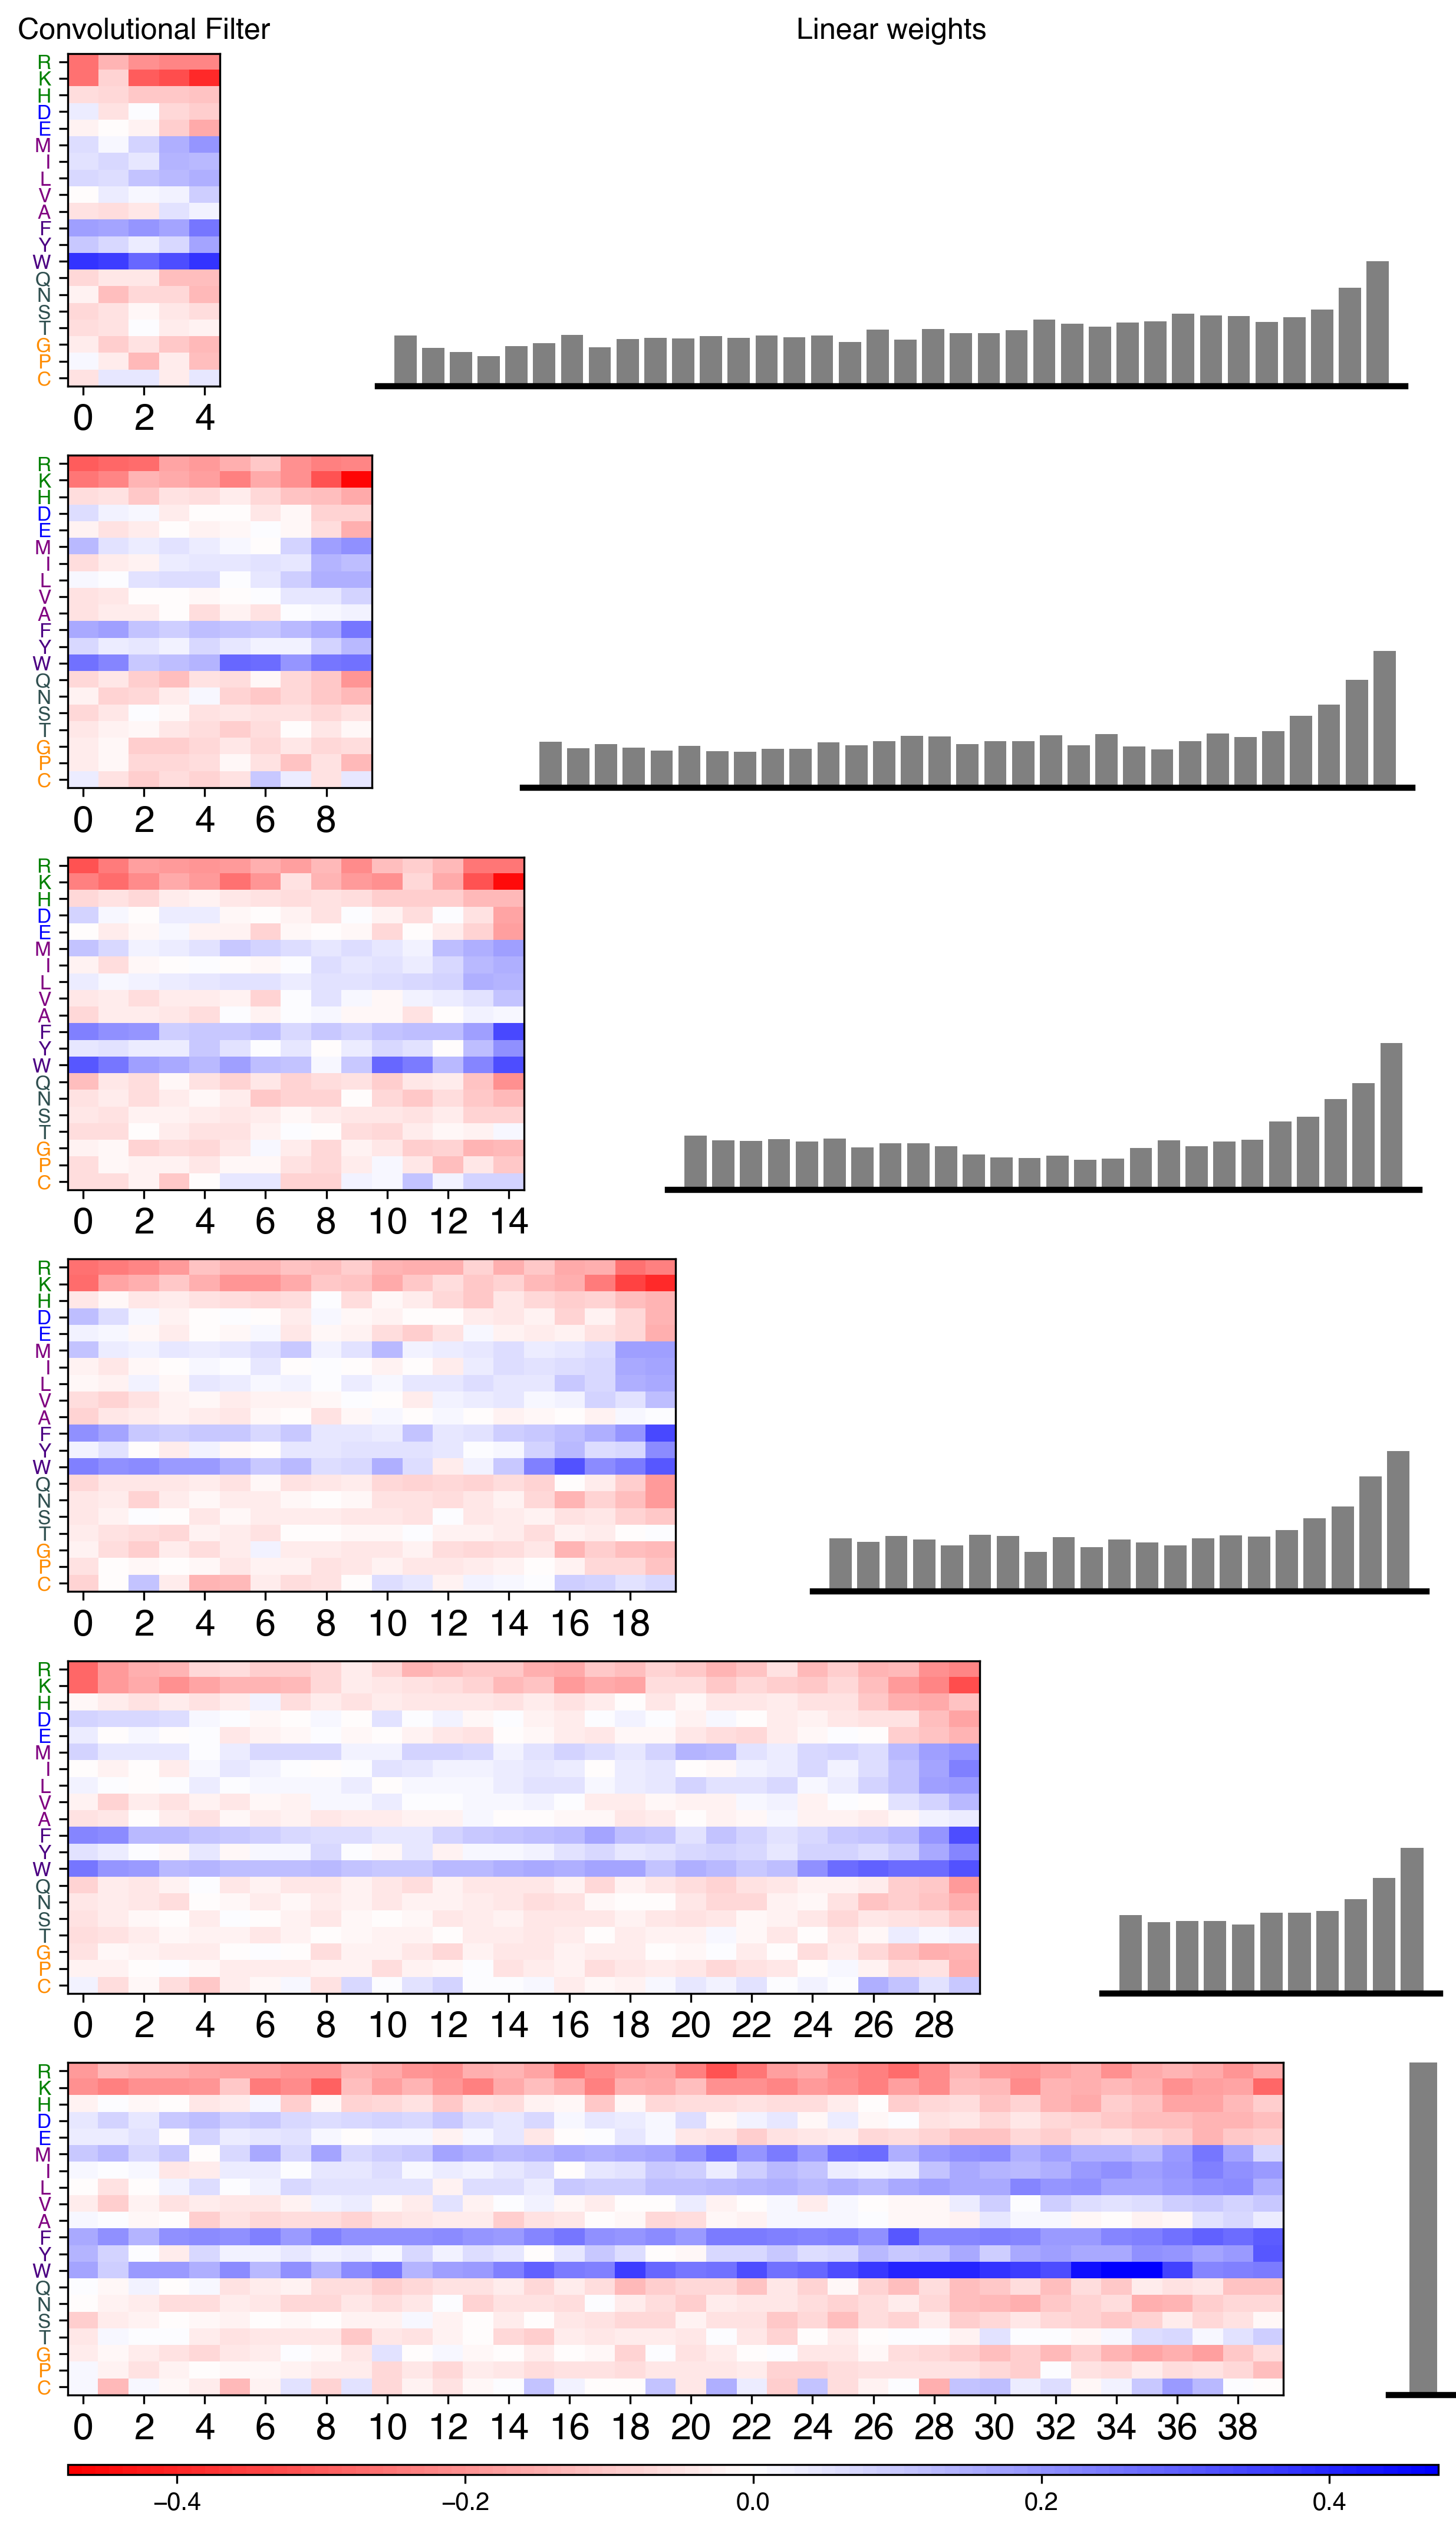

In [13]:
# K1: Plots the average parameters of the positive linear weight models 
models = [models_5, models_10, models_15, models_20, models_30, models_40]
kernel_sizes = [5, 10, 15, 20, 30, 40]
make_multi_filter_plot_mean(models, kernel_sizes)
plt.savefig("figures/three_state_K1_supp_avg_filter_sizes_pos.pdf", format='pdf', bbox_inches='tight')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


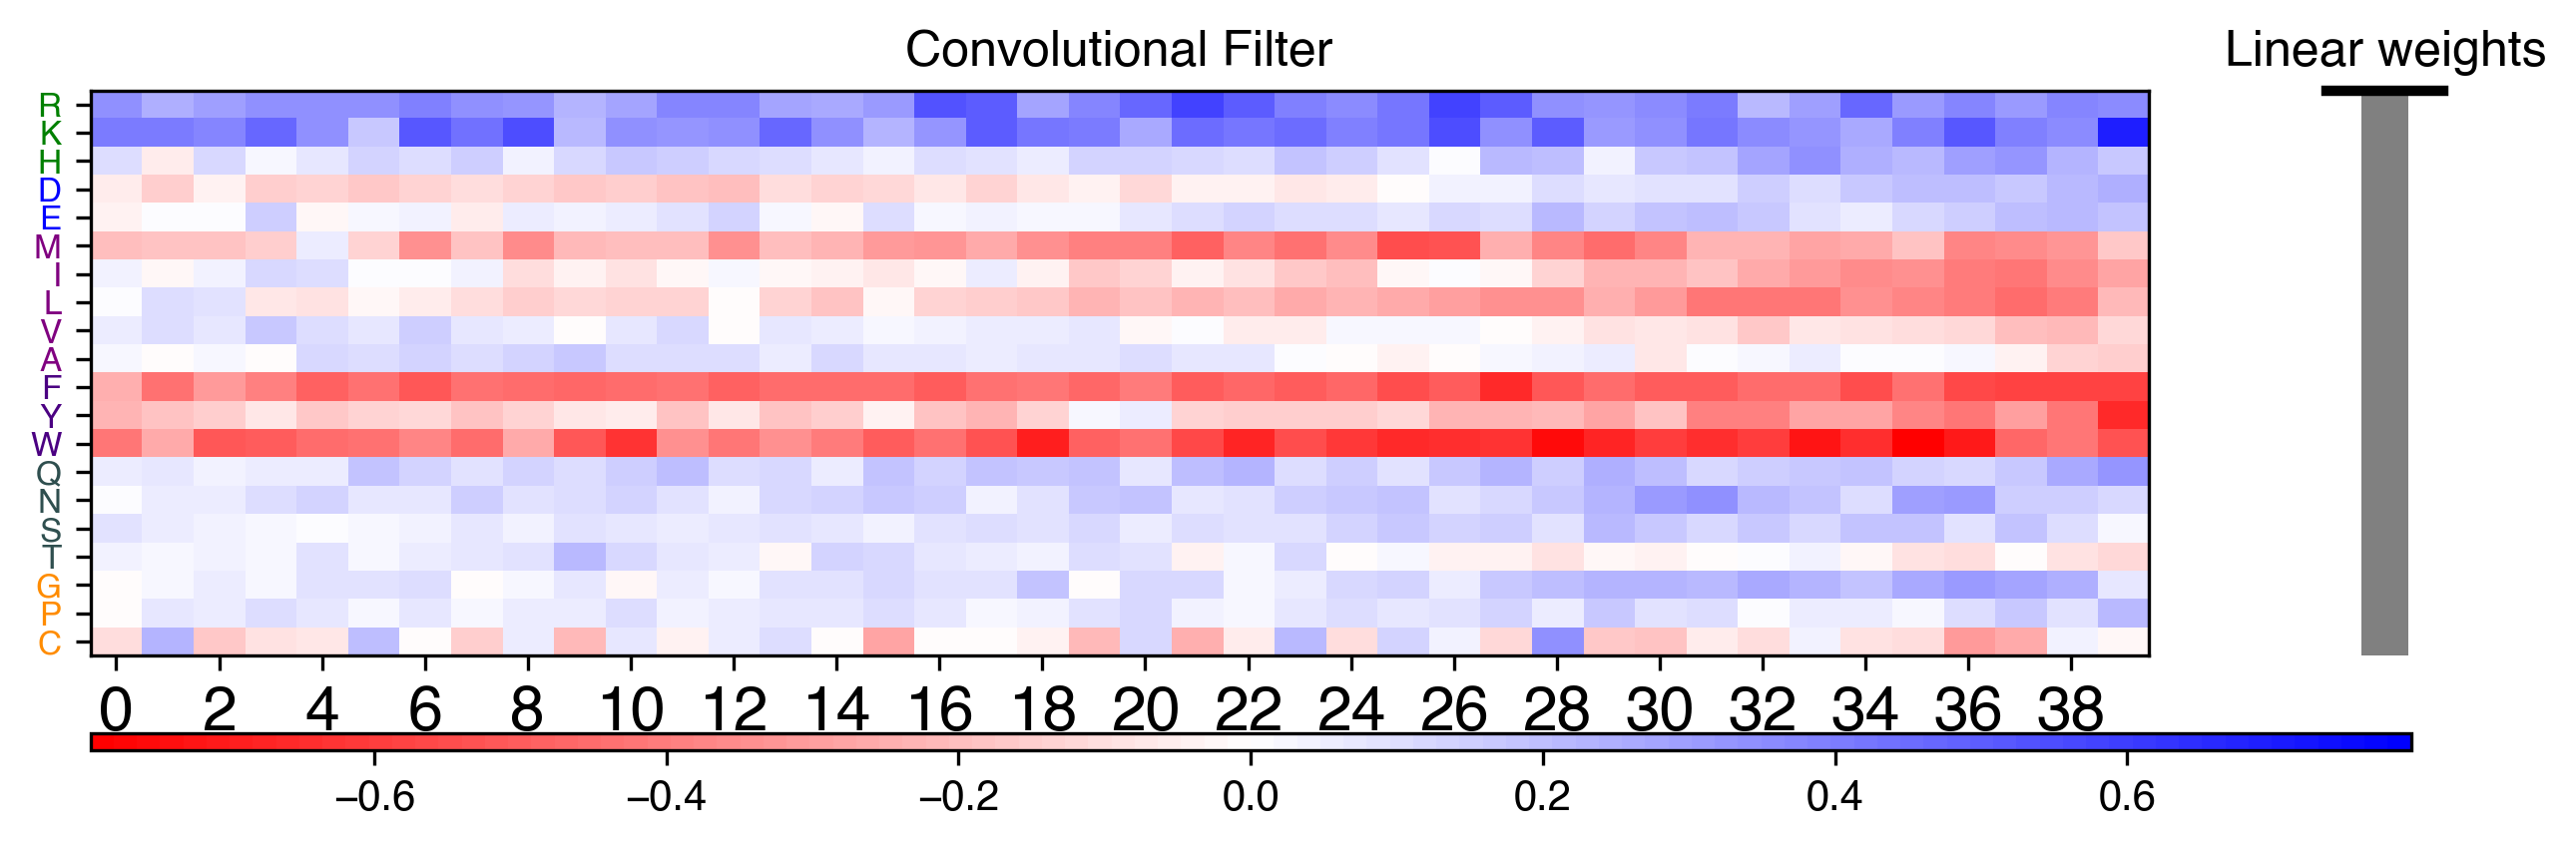

In [14]:
# K1: Plots the average parameters of the negative linear weight models 
models = [models_5, models_10, models_15, models_20, models_30, models_40]
kernel_sizes = [5, 10, 15, 20, 30, 40]
make_multi_filter_plot_mean(models, kernel_sizes, positive=False)

plt.savefig("figures/three_state_K1_supp_avg_filter_sizes_neg.pdf", format='pdf', bbox_inches='tight')


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


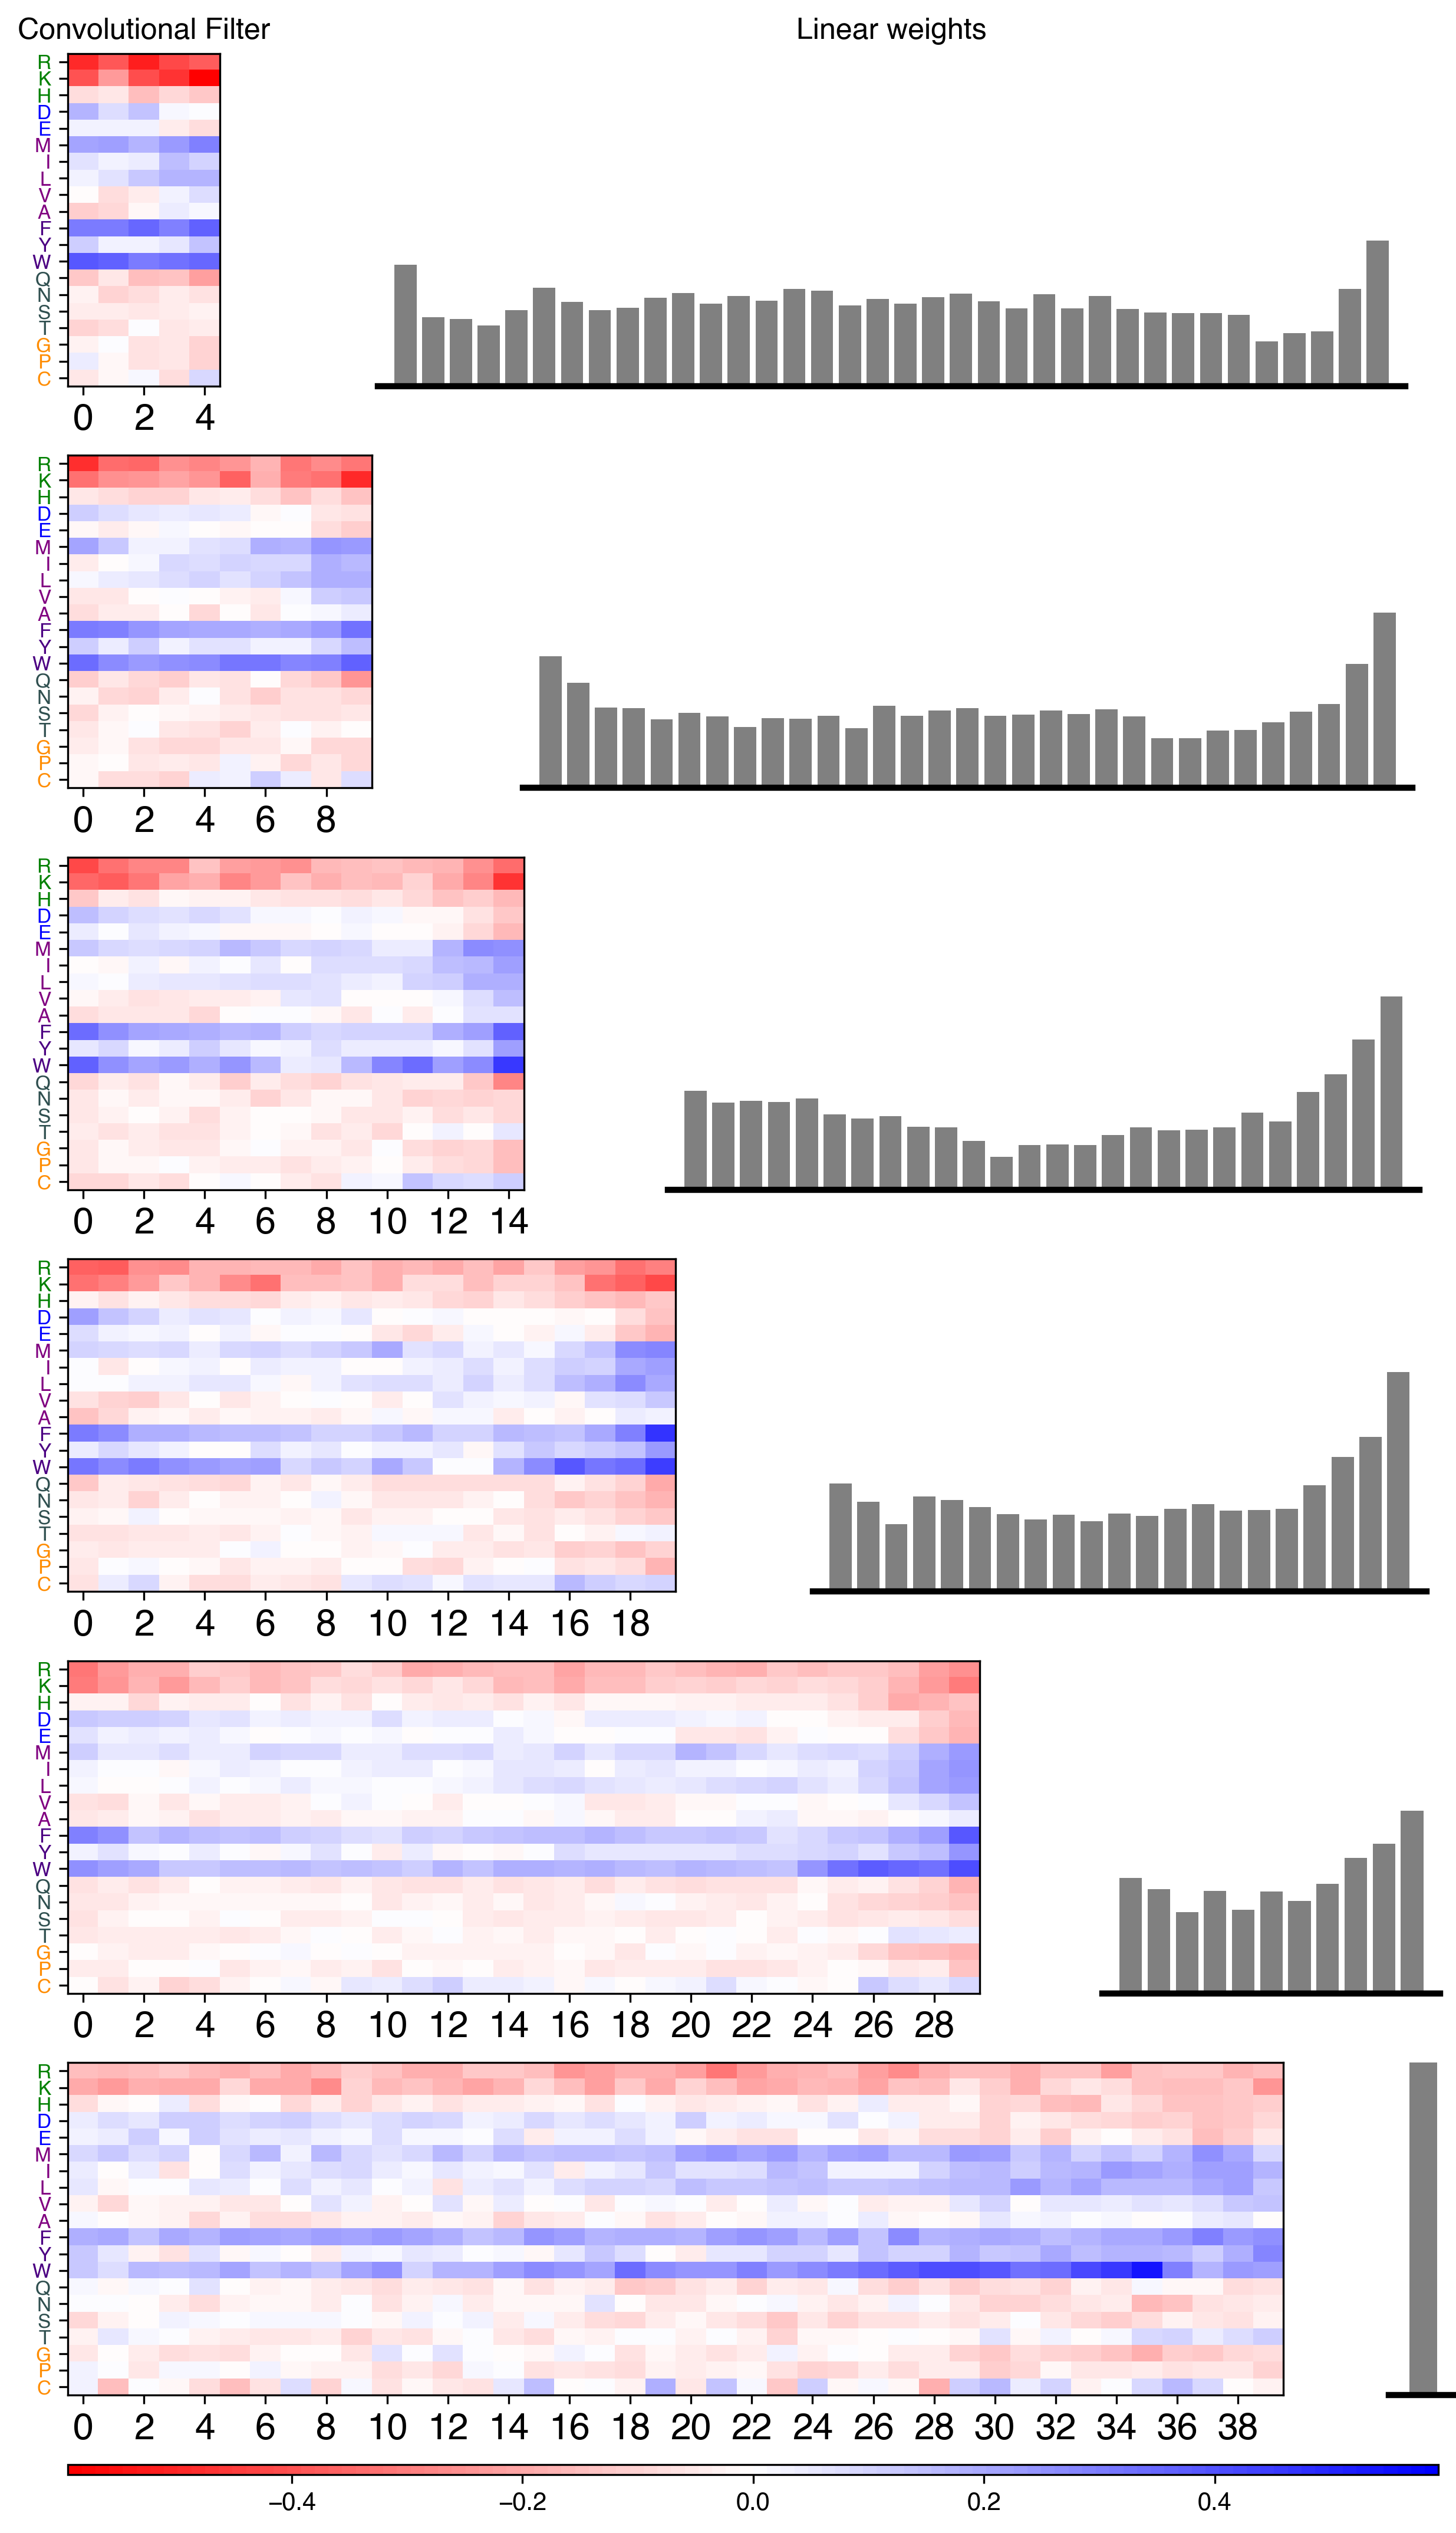

In [15]:
# K2: Plots the average parameters of the positive linear weight models 

models = [models_5, models_10, models_15, models_20, models_30, models_40]
kernel_sizes = [5, 10, 15, 20, 30, 40]
make_multi_filter_plot_mean(models, kernel_sizes, positive=True, layer_num=2)

plt.savefig("figures/three_state_K2_supp_avg_filter_sizes_pos.pdf", format='pdf', bbox_inches='tight')


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


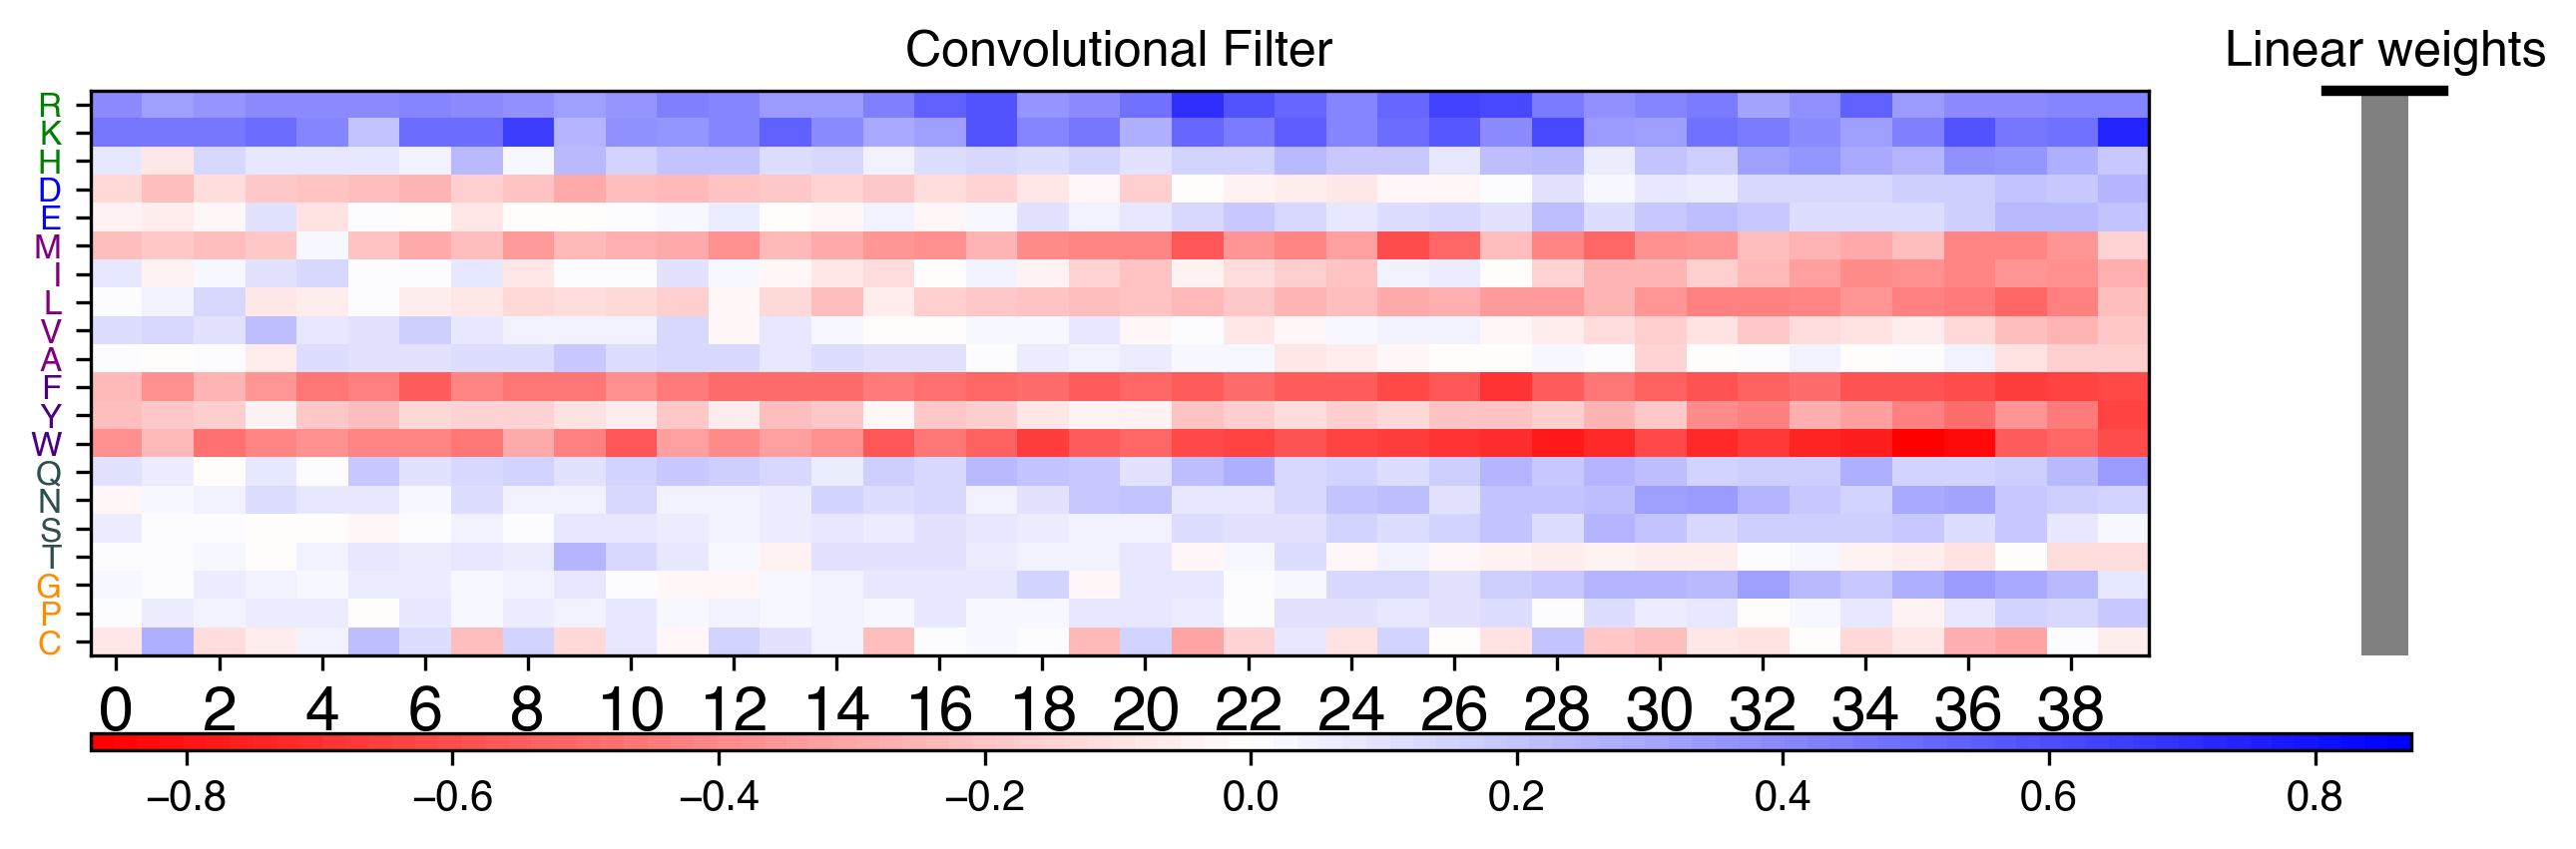

In [16]:
# K2: Plots the average parameters of the negative linear weight models 
models = [models_5, models_10, models_15, models_20, models_30, models_40]
kernel_sizes = [5, 10, 15, 20, 30, 40]
make_multi_filter_plot_mean(models, kernel_sizes, positive=False, layer_num=2)

plt.savefig("figures/three_state_K2_supp_avg_filter_sizes_neg.pdf", format='pdf', bbox_inches='tight')


# Average two state params

In [17]:
size = (1,40,20)
import torch 

def load_model(name, k, ak):
    """
    Loads ADModel_two_state_abund
    """
    model = ADModel_two_state_abund(size, "Hill", k, relu=False, abund_k=ak)
    model.load_state_dict(torch.load(f"{name}.pth"))
    return model

models_5 = []
models_10 = []
models_15 = []
models_20 = []
models_30 = []
models_40 = []

data_two_state = data_two_state[data_two_state["spearman_act_test"] > 0.15]

# Load each NN and save in a list
for index in data_two_state.index:
    K = data_two_state.loc[index, "kernel_size"]
    name = data_two_state.loc[index, "model_name"].removeprefix("../../")
    ak = int(data_two_state.loc[index, "abund_kernel_size"])
    if K == 5:
        models_5.append(load_model(name, K, ak))
    elif K == 10:
        models_10.append(load_model(name, K, ak))
    elif K == 15:
        models_15.append(load_model(name, K, ak))
    elif K == 20:
        models_20.append(load_model(name, K, ak))
    elif K == 30:
        models_30.append(load_model(name, K, ak))
    elif K == 40:
        models_40.append(load_model(name, K, ak))


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


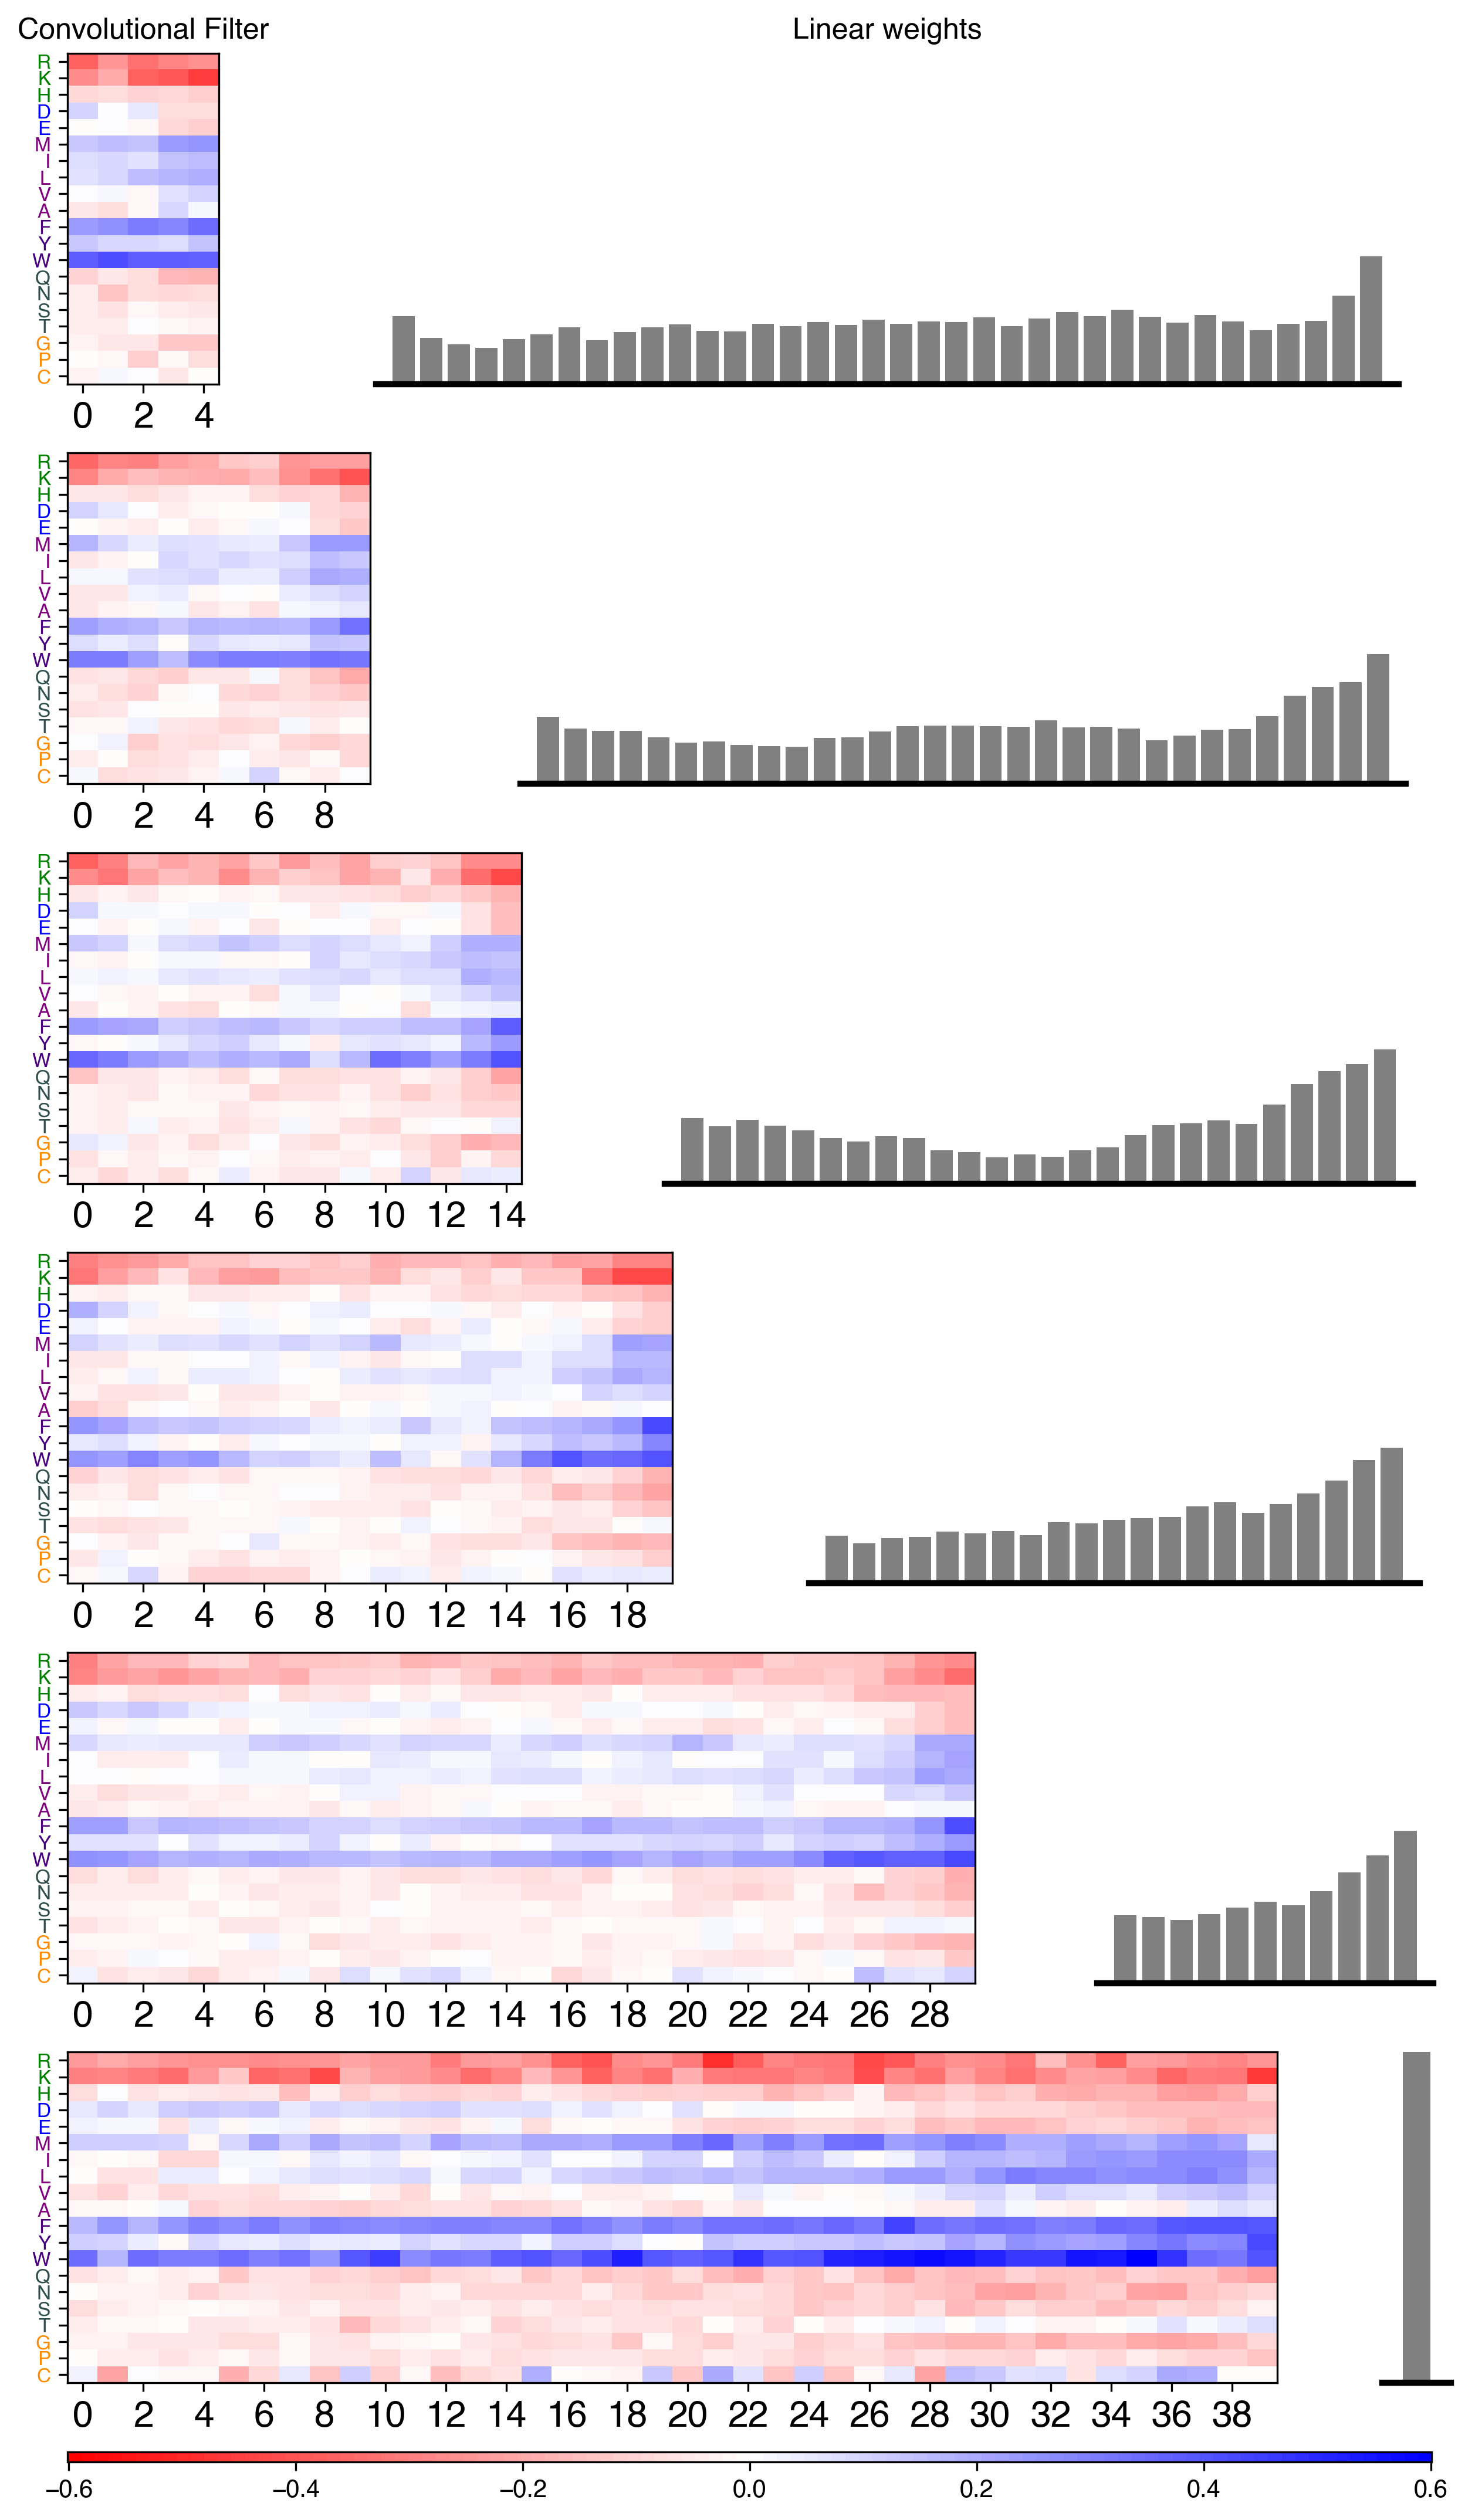

In [18]:
# Plots the average parameters of the positive linear weight models 
models = [models_5, models_10, models_15, models_20, models_30, models_40]
kernel_sizes = [5, 10, 15, 20, 30, 40]
make_multi_filter_plot_mean(models, kernel_sizes)

plt.savefig("figures/two_state_supp_avg_filter_sizes_pos.pdf", format='pdf', bbox_inches='tight')


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


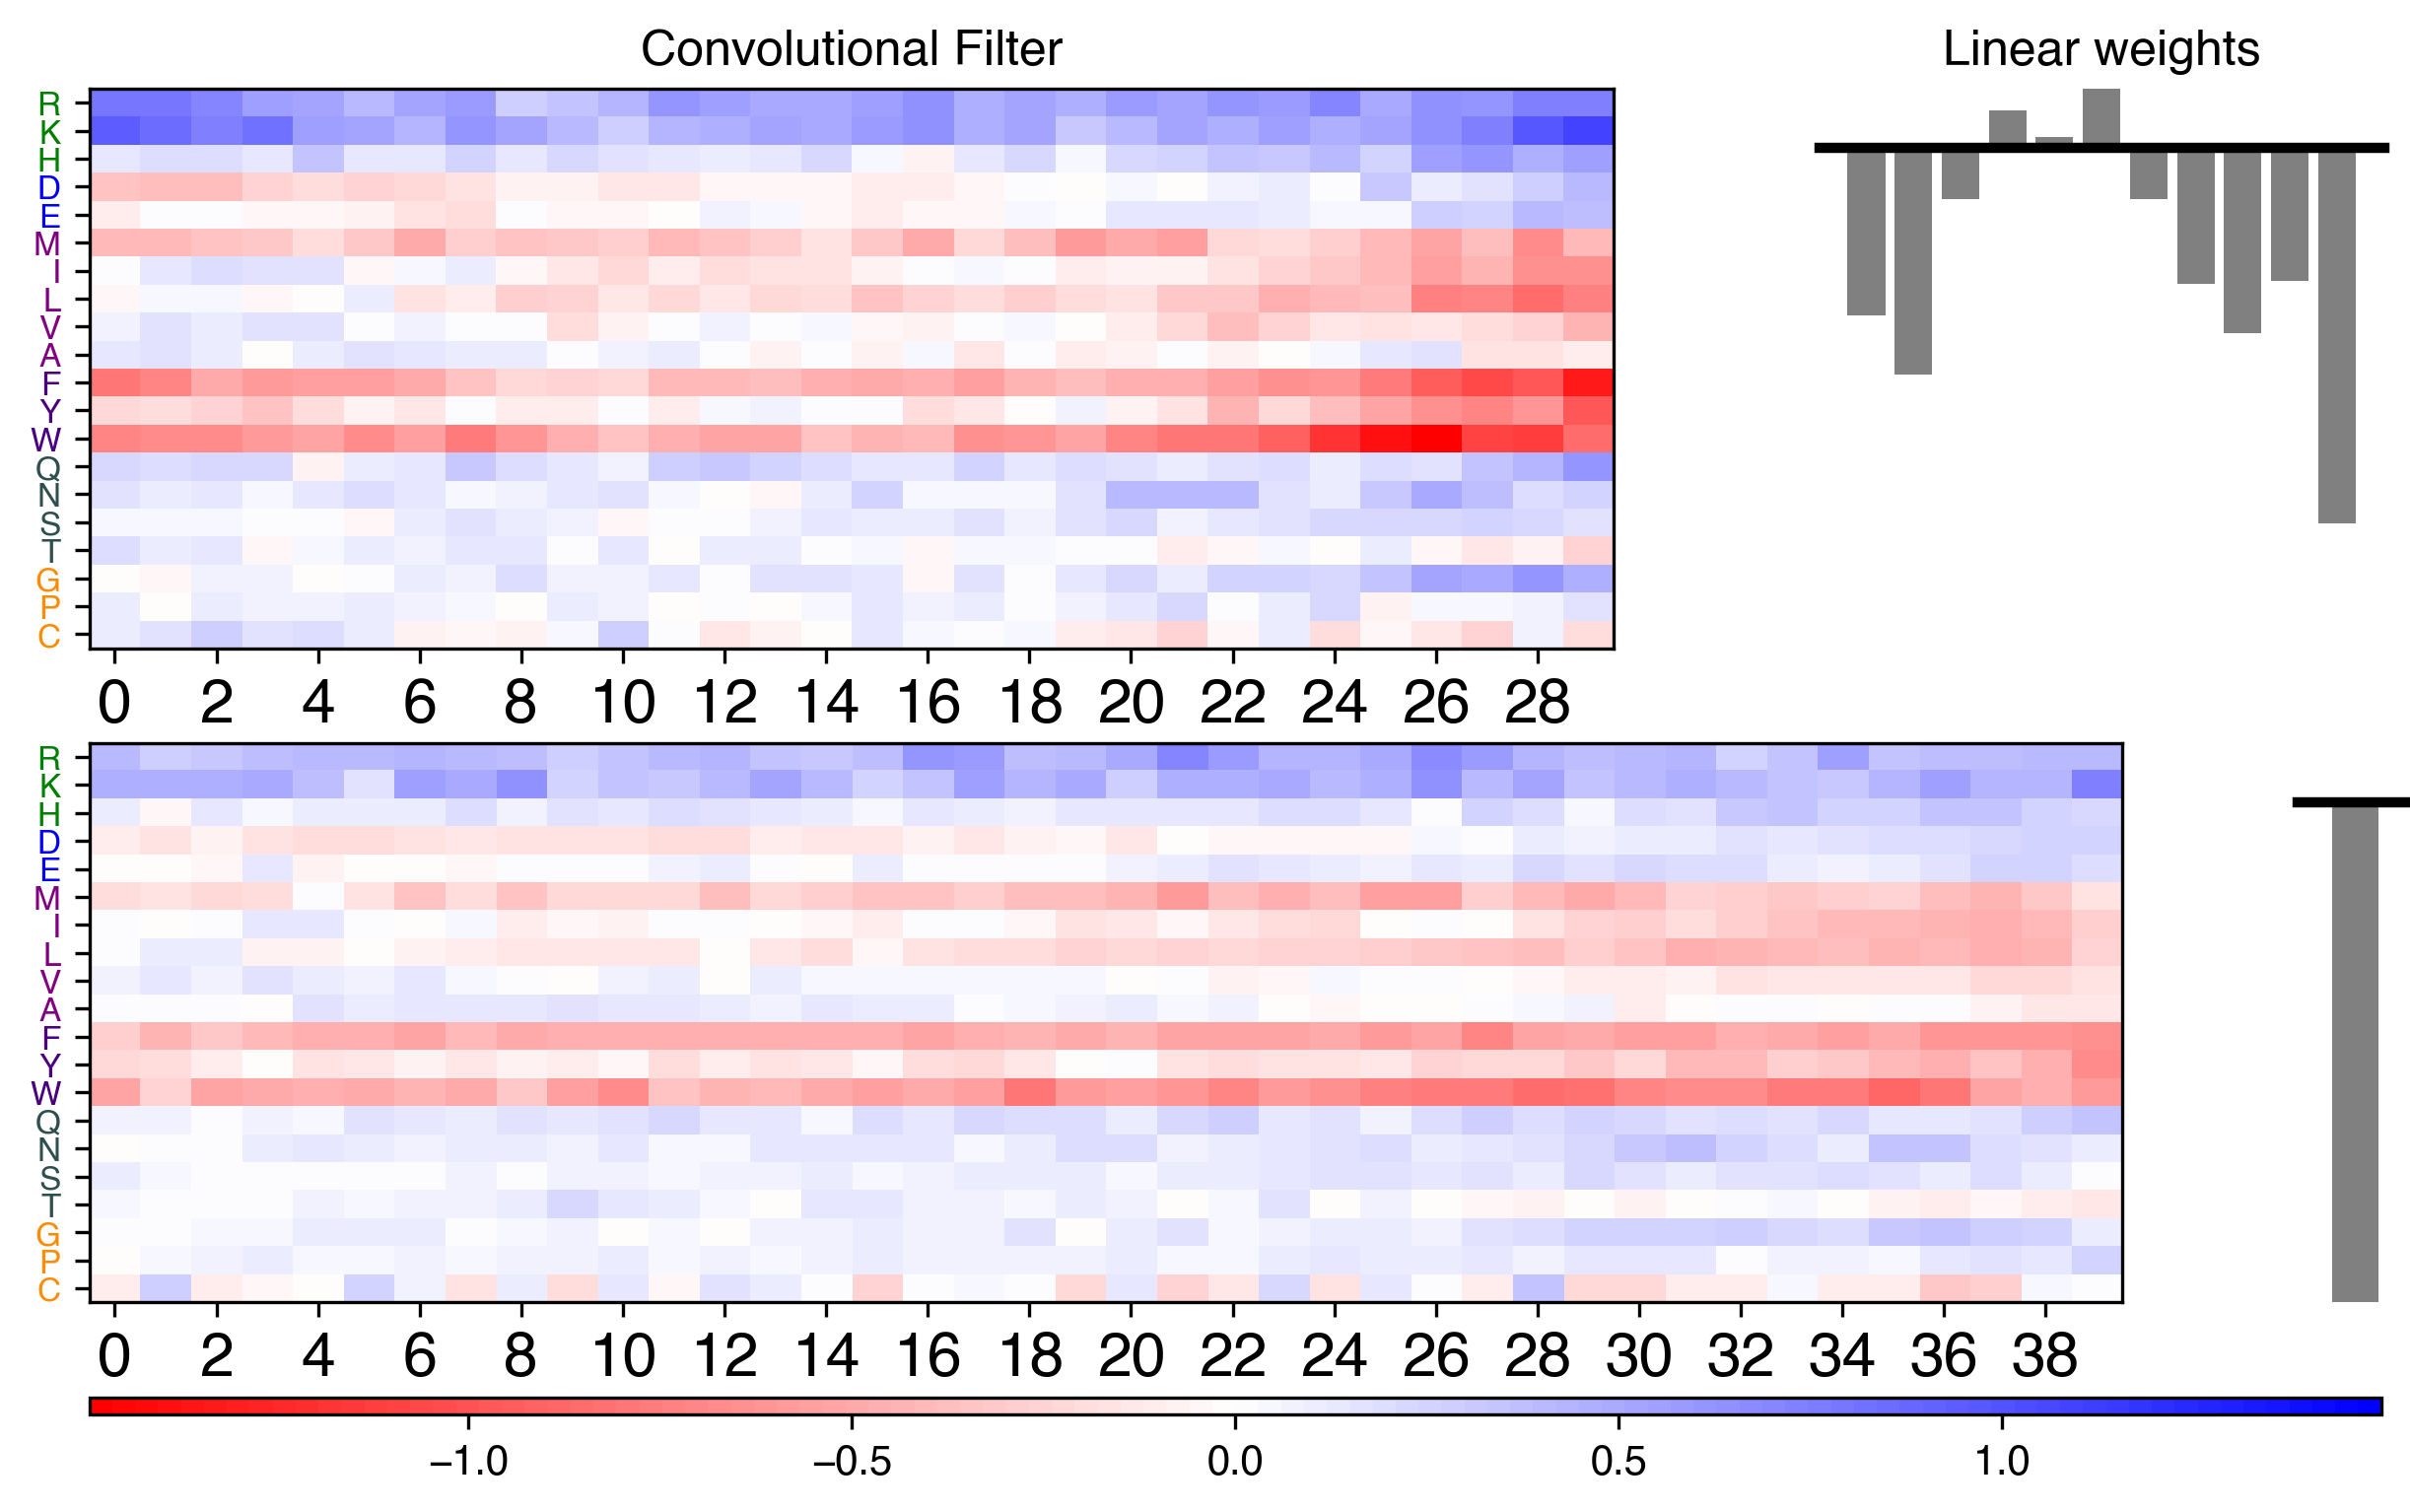

In [19]:
# Plots the average parameters of the negative linear weight models 
models = [models_5, models_10, models_15, models_20, models_30, models_40]
kernel_sizes = [5, 10, 15, 20, 30, 40]
make_multi_filter_plot_mean(models, kernel_sizes, positive=False)

plt.savefig("figures/two_state_supp_avg_filter_sizes_neg.pdf", format='pdf', bbox_inches='tight')


# Average simple act params

In [20]:
# Make sure to run this for each section! Names overlap 

size = (1,40,20)
import torch 

def load_model(name, k):
    """
    Loads ADModel_act
    """
    model = ADModel_act(size, k)
    model.load_state_dict(torch.load(f"{name}.pth"))
    return model

models_5 = []
models_10 = []
models_15 = []
models_20 = []
models_30 = []
models_40 = []

data_simple_act_filtered = data_simple_act[data_simple_act[" spearman_act_test"] > 0.6] # Remove models that didn't learn

# Load each NN and save in list
for index in data_simple_act_filtered.index:
    K = data_simple_act_filtered.loc[index, " kernel_size"]
    name = data_simple_act_filtered.loc[index, "model_name"].removeprefix("../../")
    if K == 5:
        models_5.append(load_model(name, K))
    elif K == 10:
        models_10.append(load_model(name, K))
    elif K == 15:
        models_15.append(load_model(name, K))
    elif K == 20:
        models_20.append(load_model(name, K))
    elif K == 30:
        models_30.append(load_model(name, K))
    elif K == 40:
        models_40.append(load_model(name, K))


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


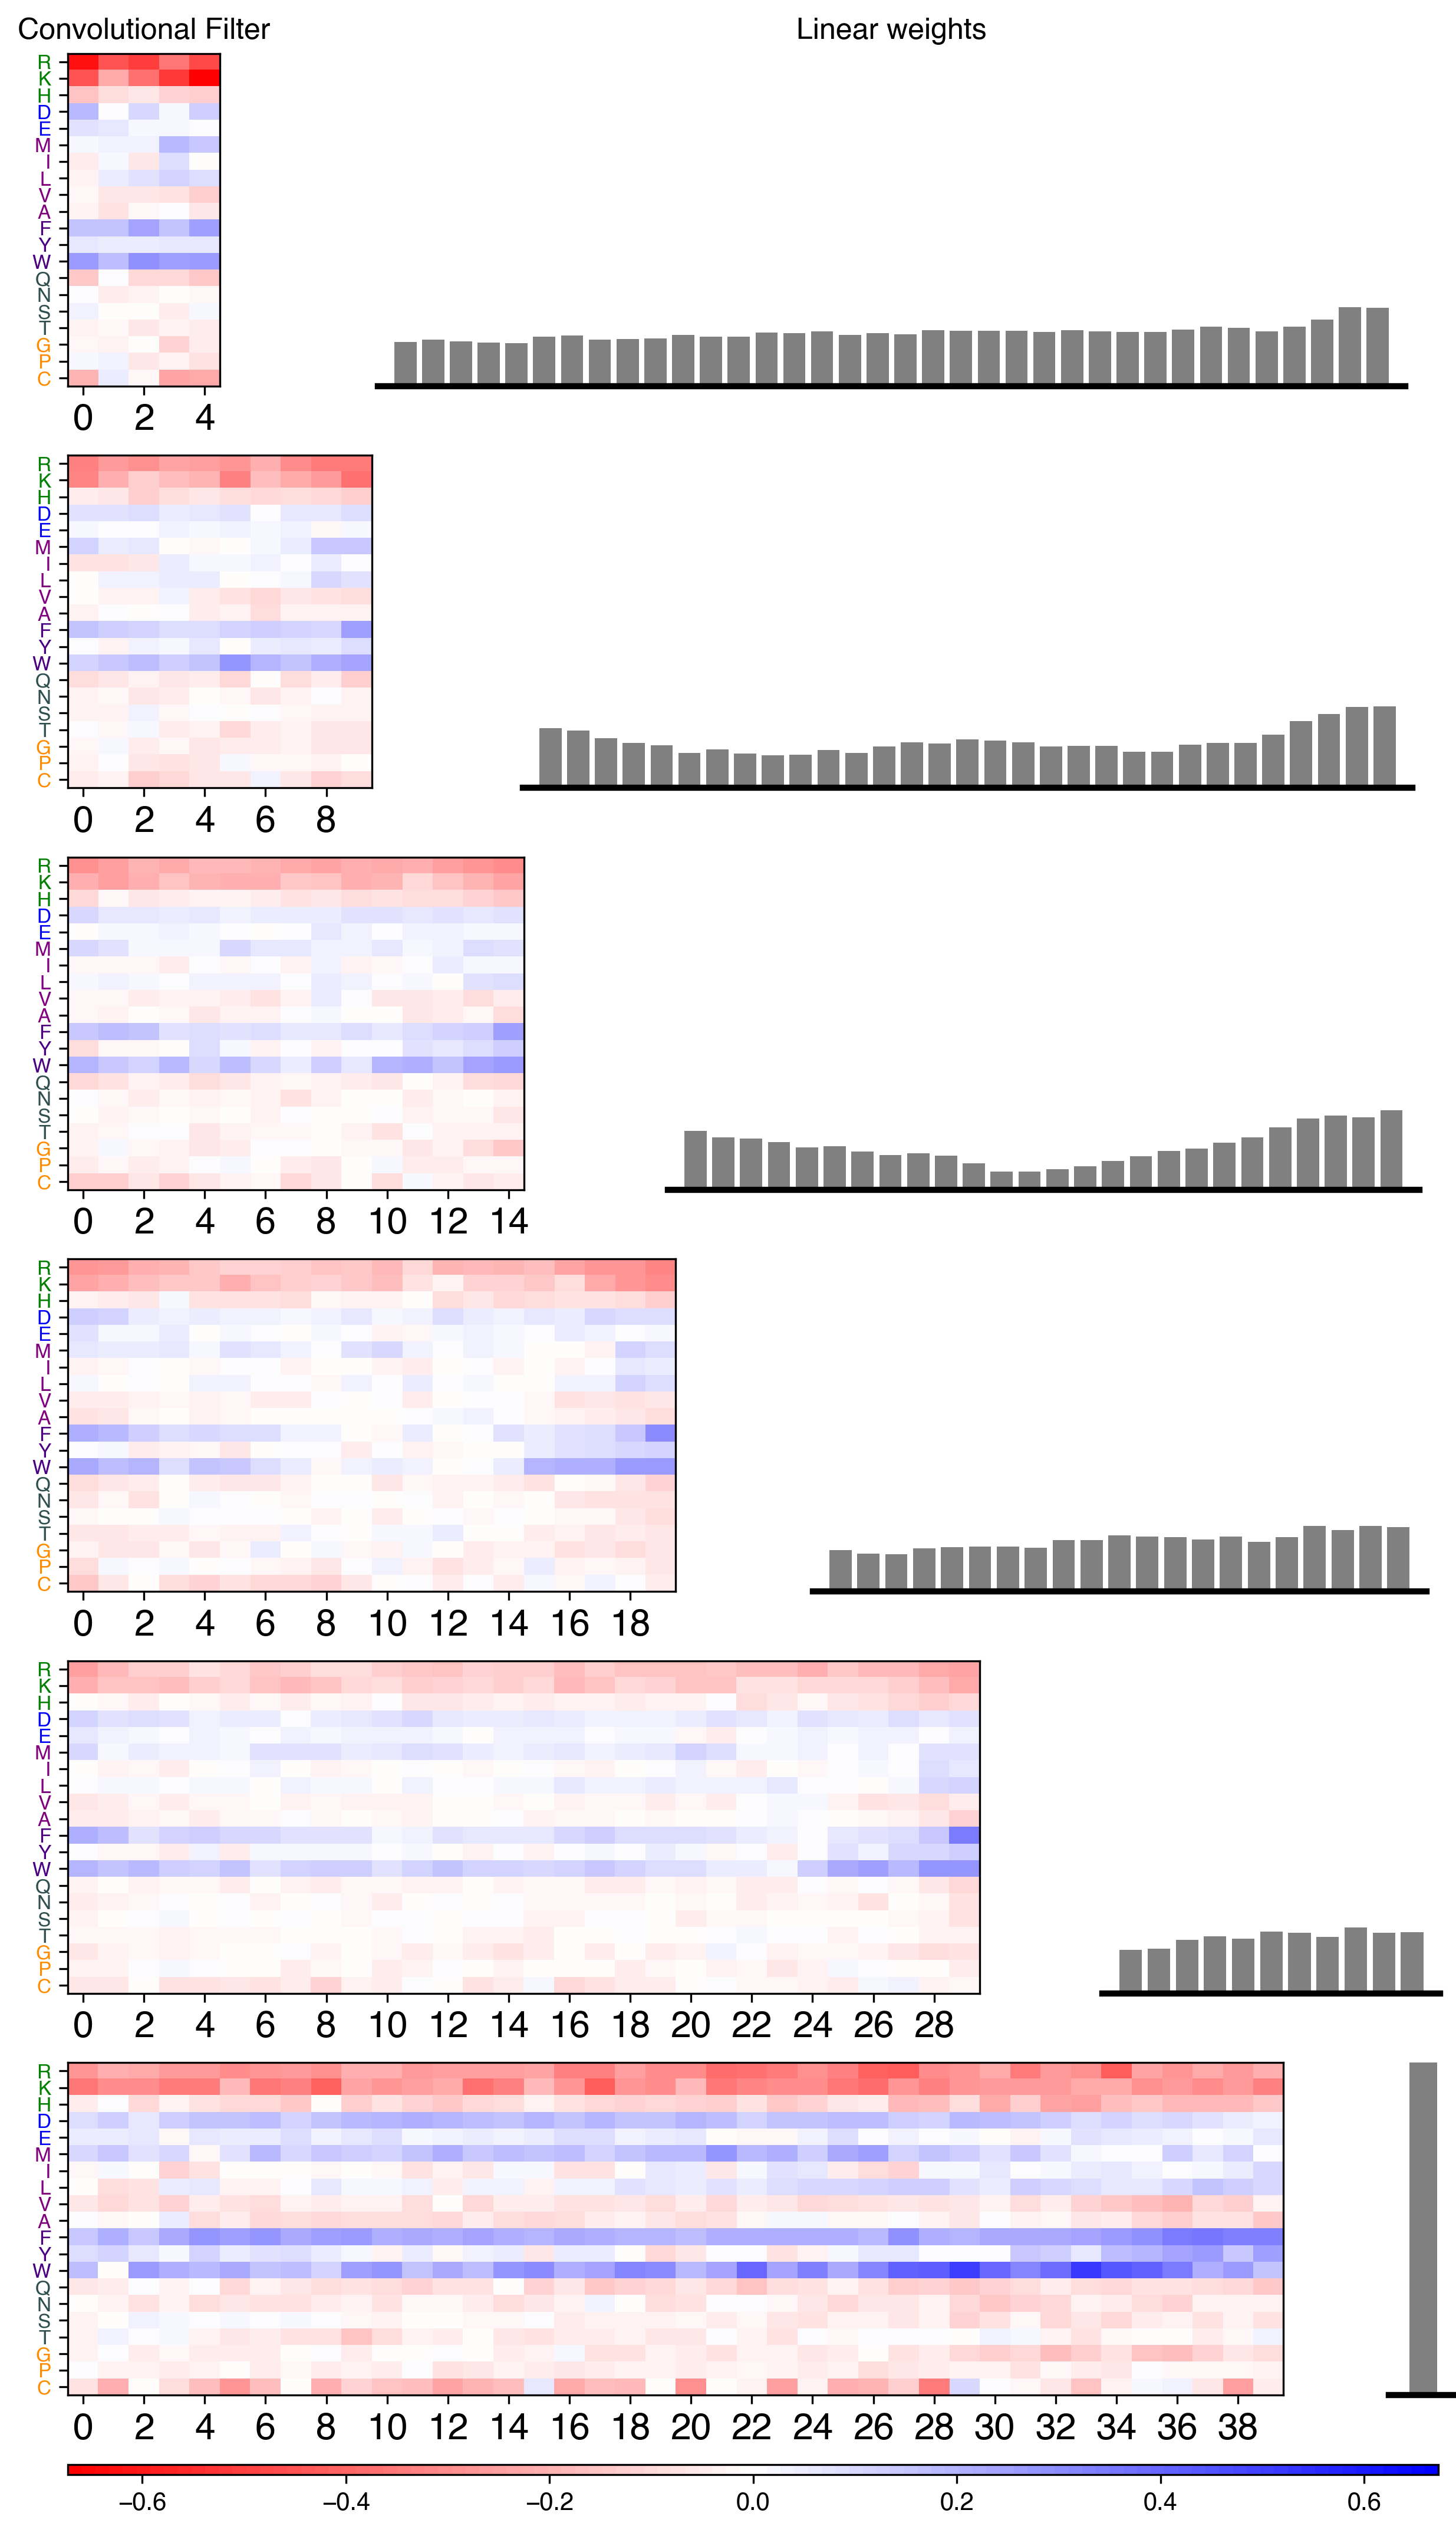

In [21]:
# Plots the average parameters of the positive linear weight models 
models = [models_5, models_10, models_15, models_20, models_30, models_40]
kernel_sizes = [5, 10, 15, 20, 30, 40]
make_multi_filter_plot_mean(models, kernel_sizes)

plt.savefig("figures/simple_act_supp_avg_filter_sizes_pos.pdf", format='pdf', bbox_inches='tight')


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


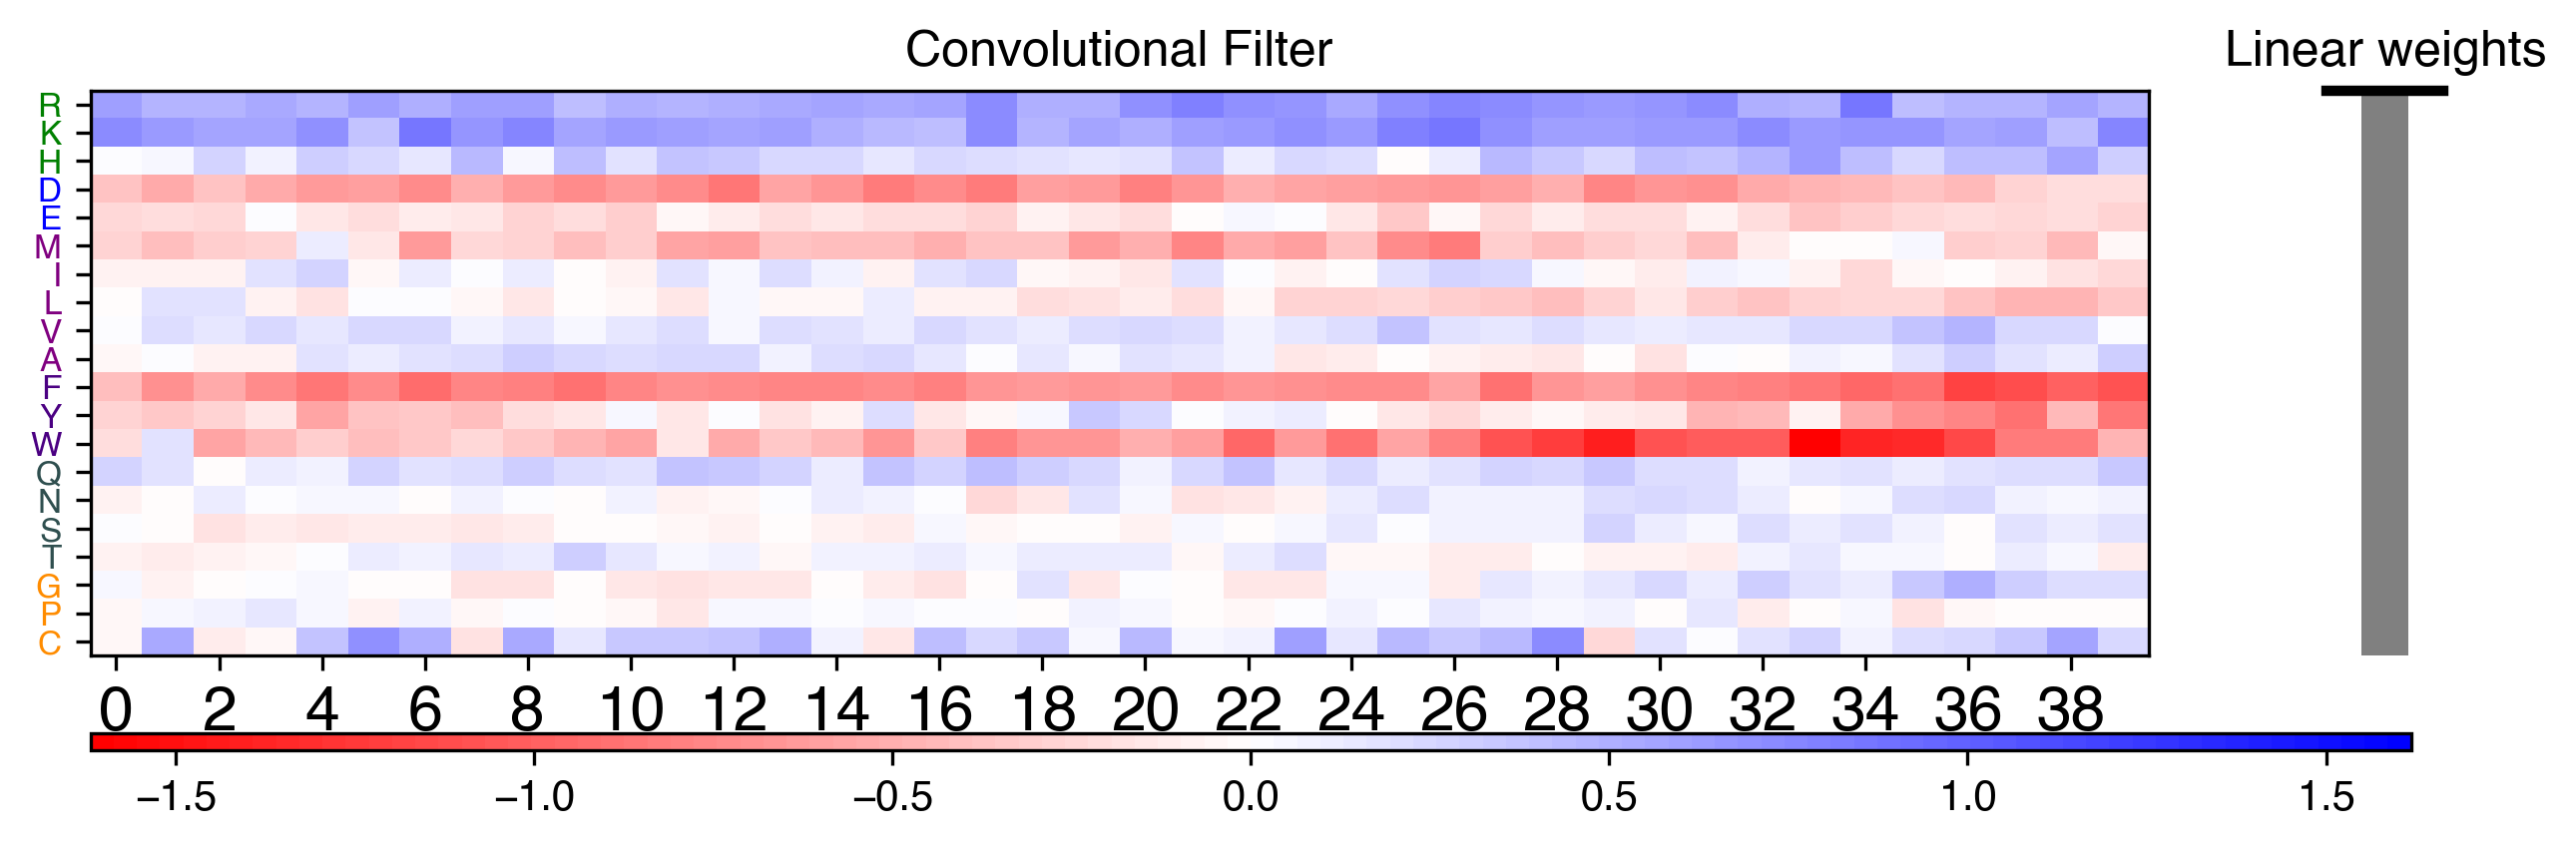

In [22]:
# Plots the average parameters of the negative linear weight models 

models = [models_5, models_10, models_15, models_20, models_30, models_40]
kernel_sizes = [5, 10, 15, 20, 30, 40]
make_multi_filter_plot_mean(models, kernel_sizes, positive=False)

plt.savefig("figures/simple_act_supp_avg_filter_sizes_neg.pdf", format='pdf', bbox_inches='tight')


# Average Simple Abund params

In [23]:
# Make sure to run this for each section! Names overlap 

size = (1,40,20)
import torch 

def load_model(name, k):
    """
    Loads ADModel_abund 
    """
    model = ADModel_abund(size, k)
    model.load_state_dict(torch.load(f"{name}.pth"))
    return model

models_5 = []
models_10 = []
models_15 = []
models_20 = []
models_30 = []
models_40 = []

data_simple_abund_filtered = data_simple_abund[data_simple_abund[" spearman_abund_test"] > 0.15]

# Save loaded models in lists
for index in data_simple_abund_filtered.index:
    K = data_simple_abund_filtered.loc[index, " kernel_size"]
    name = data_simple_abund_filtered.loc[index, "model_name"].removeprefix("../../")
    if K == 5:
        models_5.append(load_model(name, K))
    elif K == 10:
        models_10.append(load_model(name, K))
    elif K == 15:
        models_15.append(load_model(name, K))
    elif K == 20:
        models_20.append(load_model(name, K))
    elif K == 30:
        models_30.append(load_model(name, K))
    elif K == 40:
        models_40.append(load_model(name, K))


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


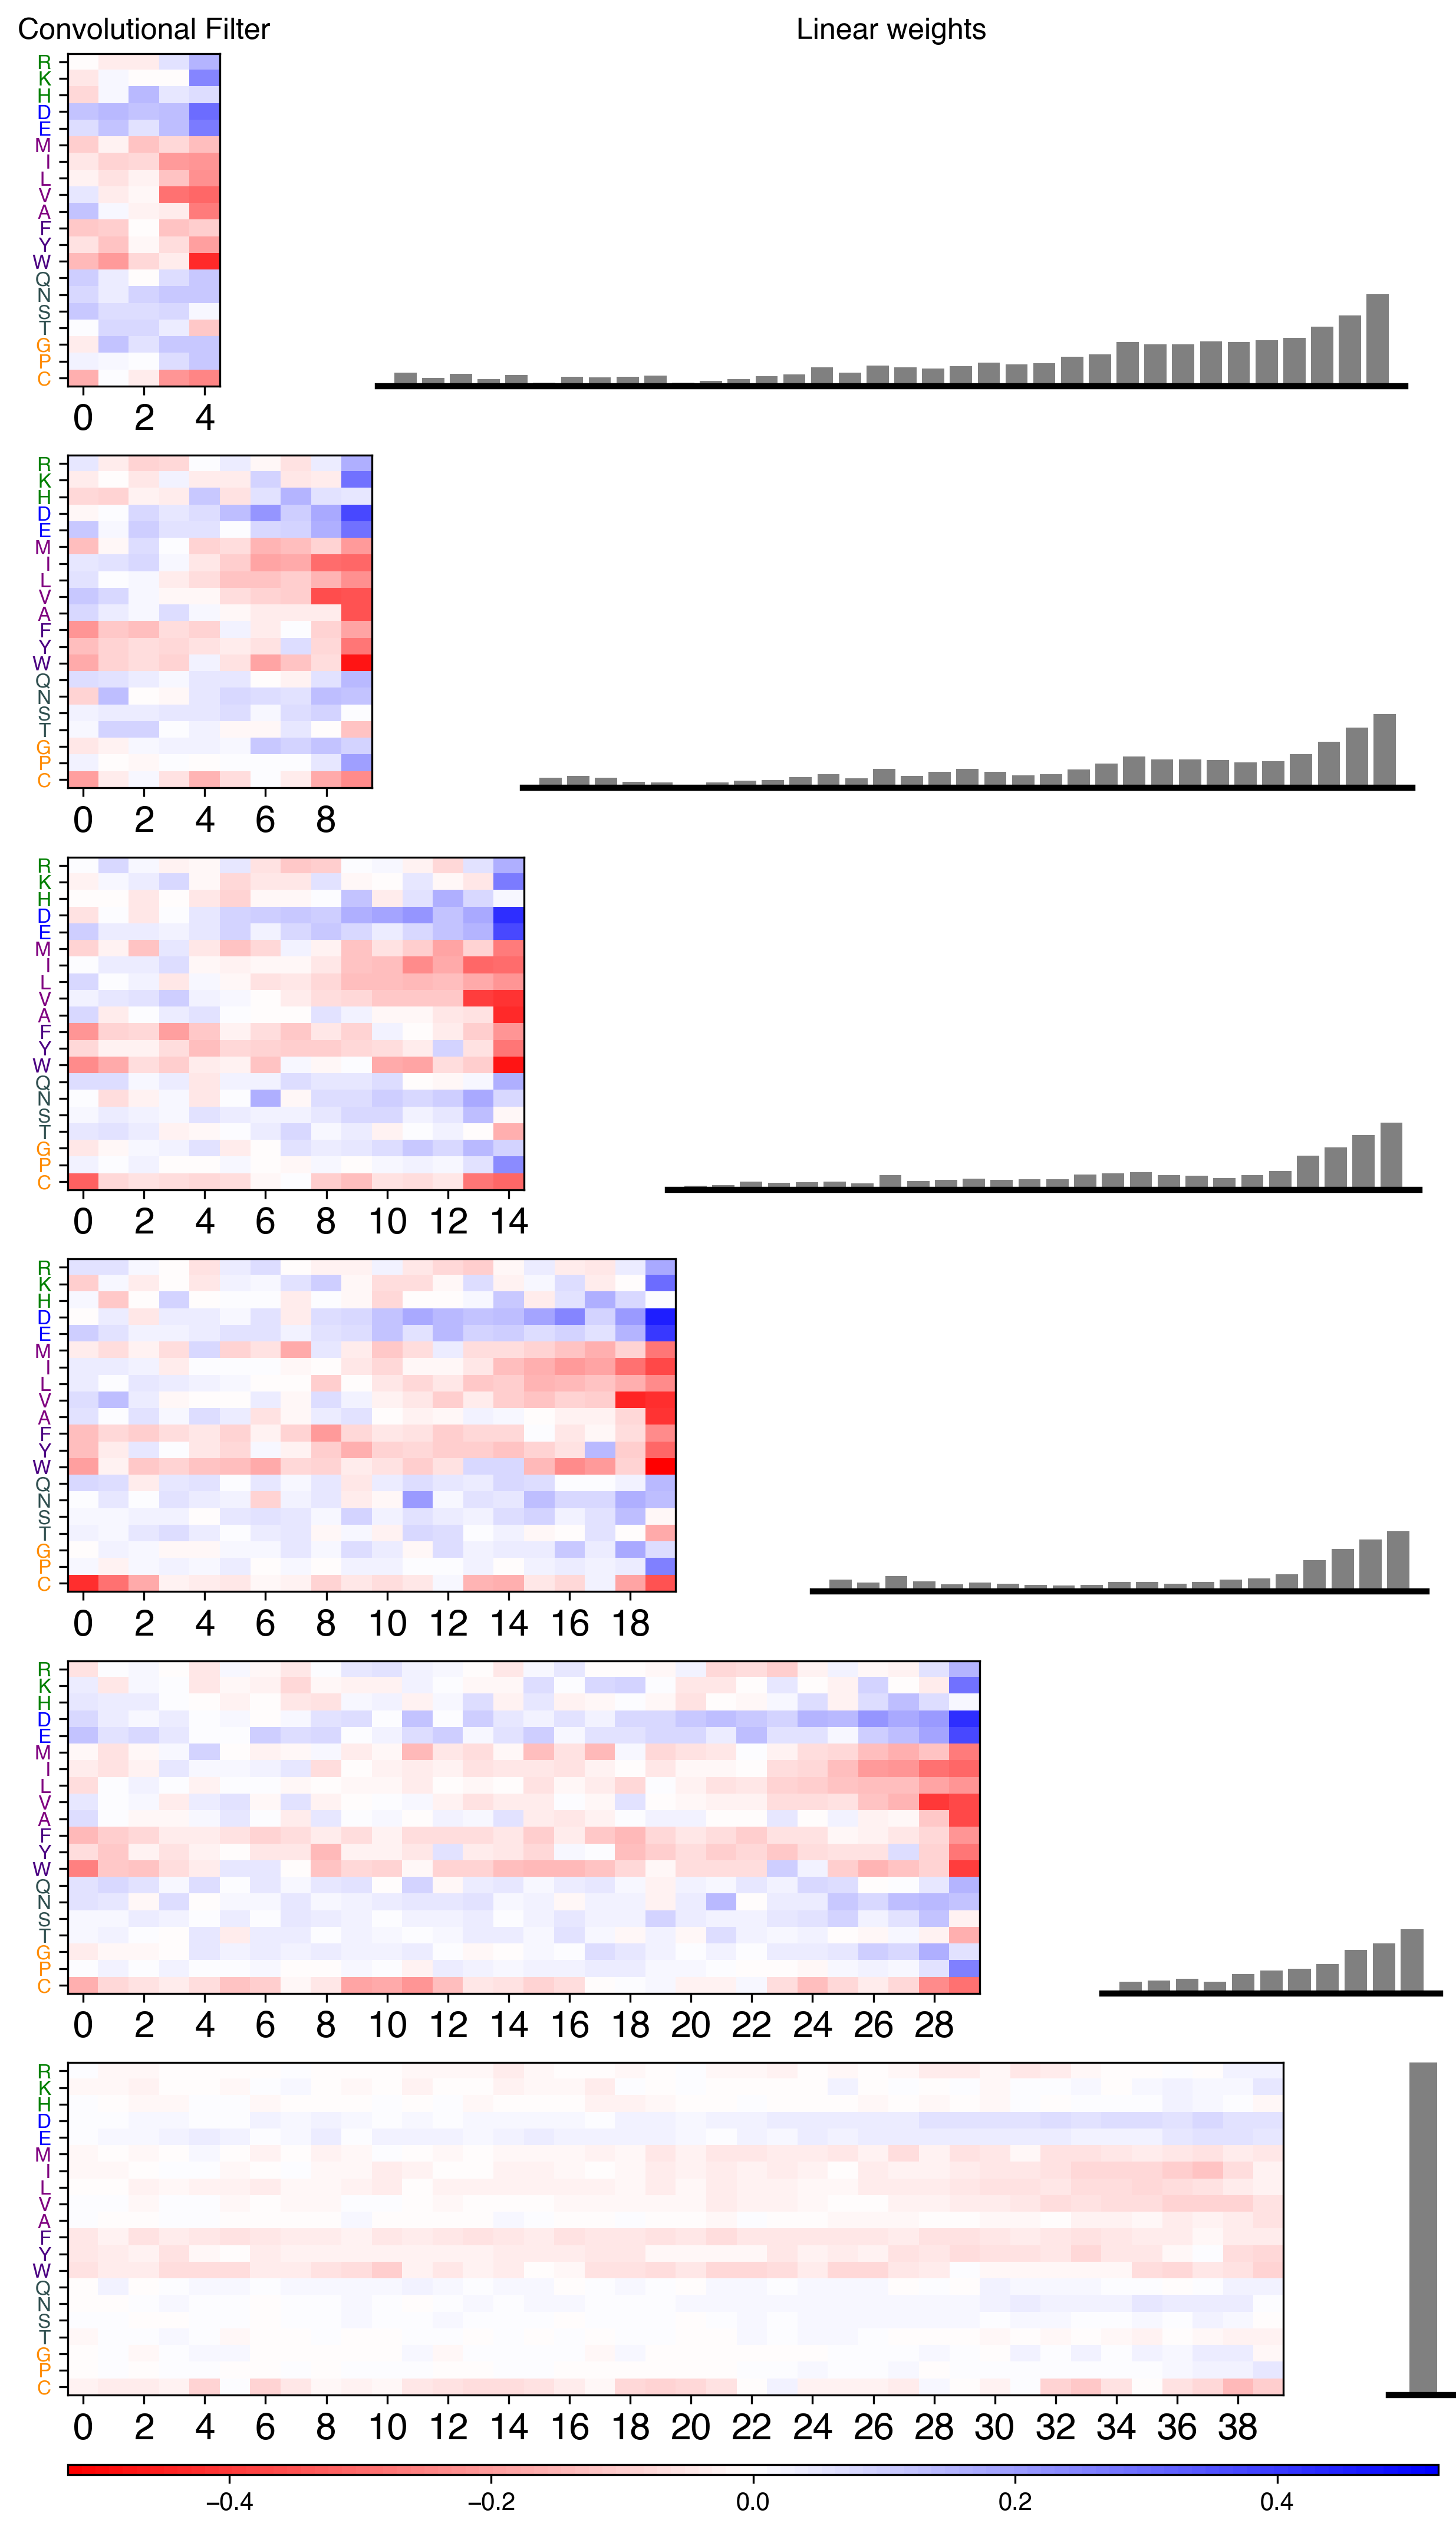

In [24]:
# Plots the average parameters of the positive linear weight models 
models = [models_5, models_10, models_15, models_20, models_30, models_40]
kernel_sizes = [5, 10, 15, 20, 30, 40]
make_multi_filter_plot_mean(models, kernel_sizes, positive=True)

plt.savefig("figures/simple_abund_supp_avg_filter_sizes_pos.pdf", format='pdf', bbox_inches='tight')


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


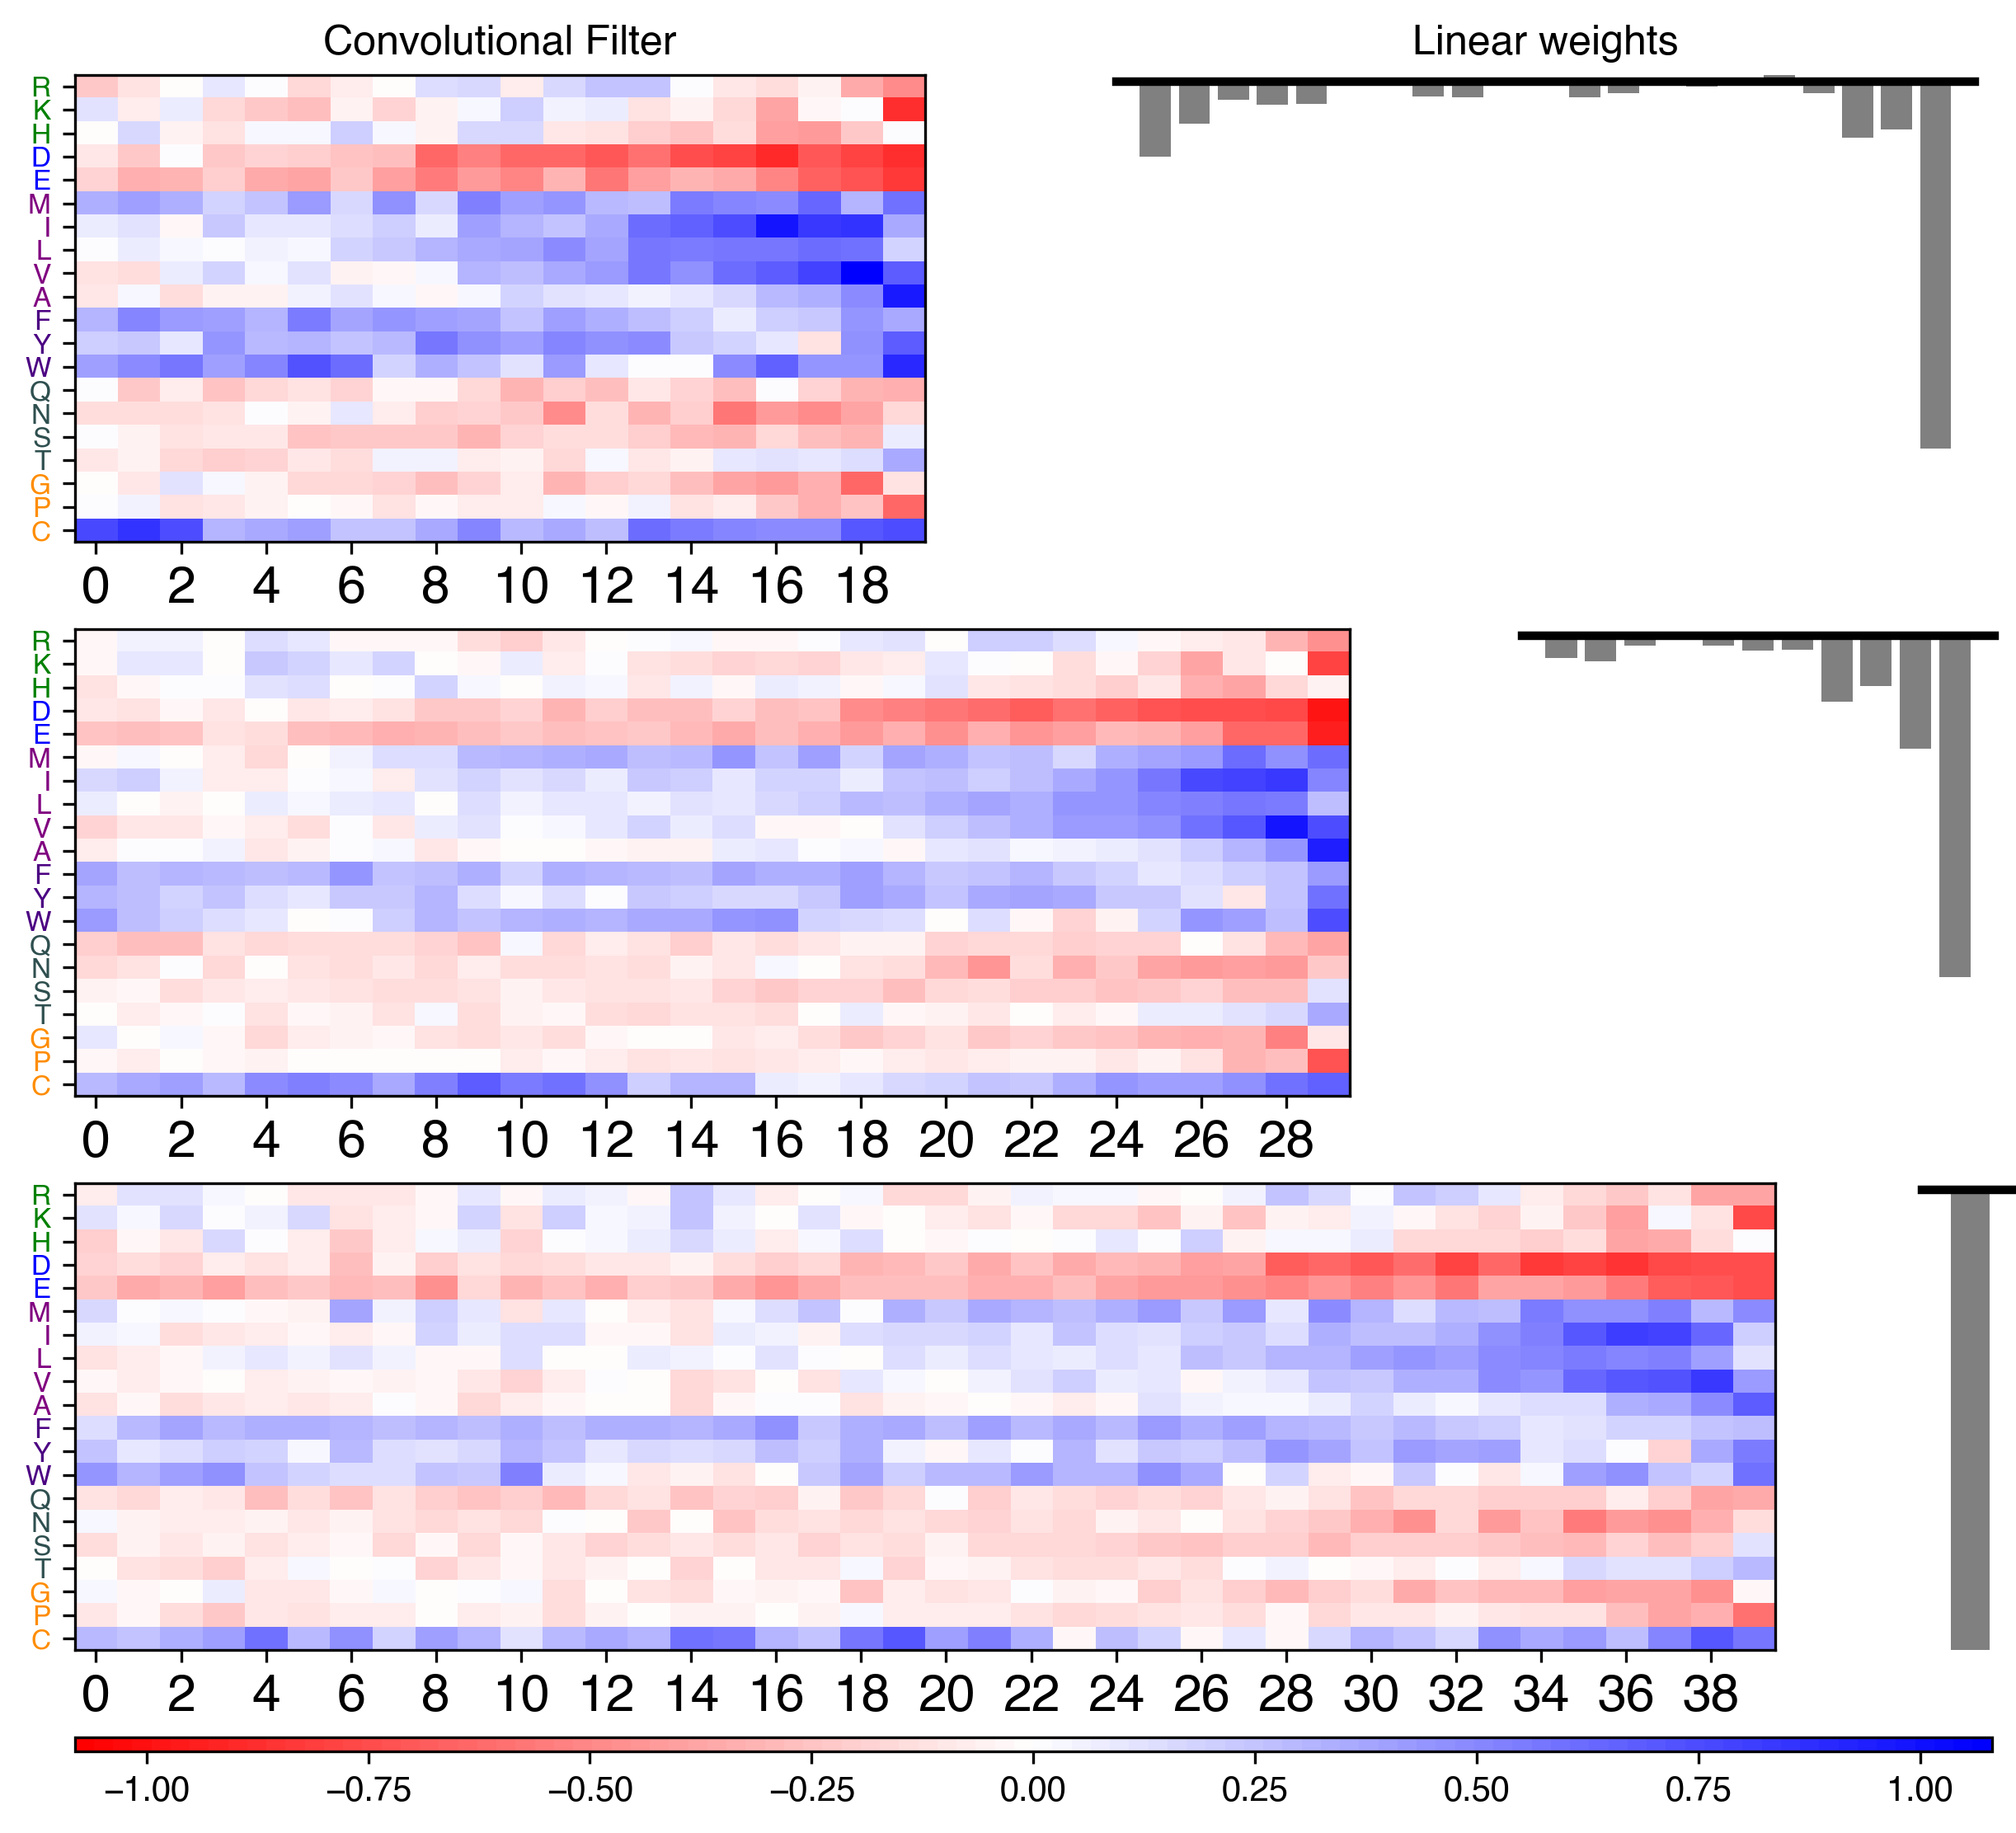

In [25]:
# Plots the average parameters of the negative linear weight models 

models = [models_5, models_10, models_15, models_20, models_30, models_40]
kernel_sizes = [5, 10, 15, 20, 30, 40]
make_multi_filter_plot_mean(models, kernel_sizes, positive=False)


plt.savefig("figures/simple_abund_supp_avg_filter_sizes_neg.pdf", format='pdf', bbox_inches='tight')


# Best perfoming individual models - Abund

In [26]:
best_abund = data_simple_abund.sort_values("sum_rank", ascending=True).drop_duplicates(" kernel_size", keep="first")
best_abund

,index,model_name,model_type,kernel_size,activity_fun,negative_pen,weight_pen,hill_value,spearman_abund_test,spearman_act_test,...,pearson_abund_train,pearson_act_train,K1_negative,K2_negative,abund_negative,relu,total_params,r1,r2,sum_rank
0,0,../../model_data/simple_abundmodel_b10_e200_L0...,simple_abund,5,NaN,NaN,0.1,NaN,0.510685,NaN,...,0.585179,NaN,NaN,NaN,NaN,NaN,139,0,0,0
1,1,../../model_data/simple_abundmodel_b10_e200_L0...,simple_abund,10,NaN,NaN,0.1,NaN,0.539465,NaN,...,0.601241,NaN,NaN,NaN,NaN,NaN,234,1,1,2
2,2,../../model_data/simple_abundmodel_b10_e200_L0...,simple_abund,15,NaN,NaN,0.1,NaN,0.556426,NaN,...,0.615284,NaN,NaN,NaN,NaN,NaN,329,2,2,4
3,3,../../model_data/simple_abundmodel_b10_e200_L0...,simple_abund,20,NaN,NaN,0.1,NaN,0.564709,NaN,...,0.629037,NaN,NaN,NaN,NaN,NaN,424,3,3,6
4,4,../../model_data/simple_abundmodel_b10_e200_L0...,simple_abund,30,NaN,NaN,0.1,NaN,0.573874,NaN,...,0.647314,NaN,NaN,NaN,NaN,NaN,614,4,4,8
5,5,../../model_data/simple_abundmodel_b10_e200_L0...,simple_abund,40,NaN,NaN,0.1,NaN,0.547747,NaN,...,0.649635,NaN,NaN,NaN,NaN,NaN,804,5,5,10


In [27]:
size = (1,40,20)
import torch 

def load_model(name, k):
    model = ADModel_abund(size, k)
    model.load_state_dict(torch.load(f"{name}.pth"))
    return model


for index in best_abund.index:
    K = best_abund.loc[index, " kernel_size"]
    name = best_abund.loc[index, "model_name"].removeprefix("../../")
    # ak = int(data_simple_act.loc[index, "abund_kernel_size"])
    if K == 5:
        model_5 = load_model(name, K)
    elif K == 10:
        model_10 = load_model(name, K)
    elif K == 15:
        model_15 = load_model(name, K)
    elif K == 20:
        model_20 = load_model(name, K)
    elif K == 30:
        model_30 = load_model(name, K)
    elif K == 40:
        model_40 = load_model(name, K)


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


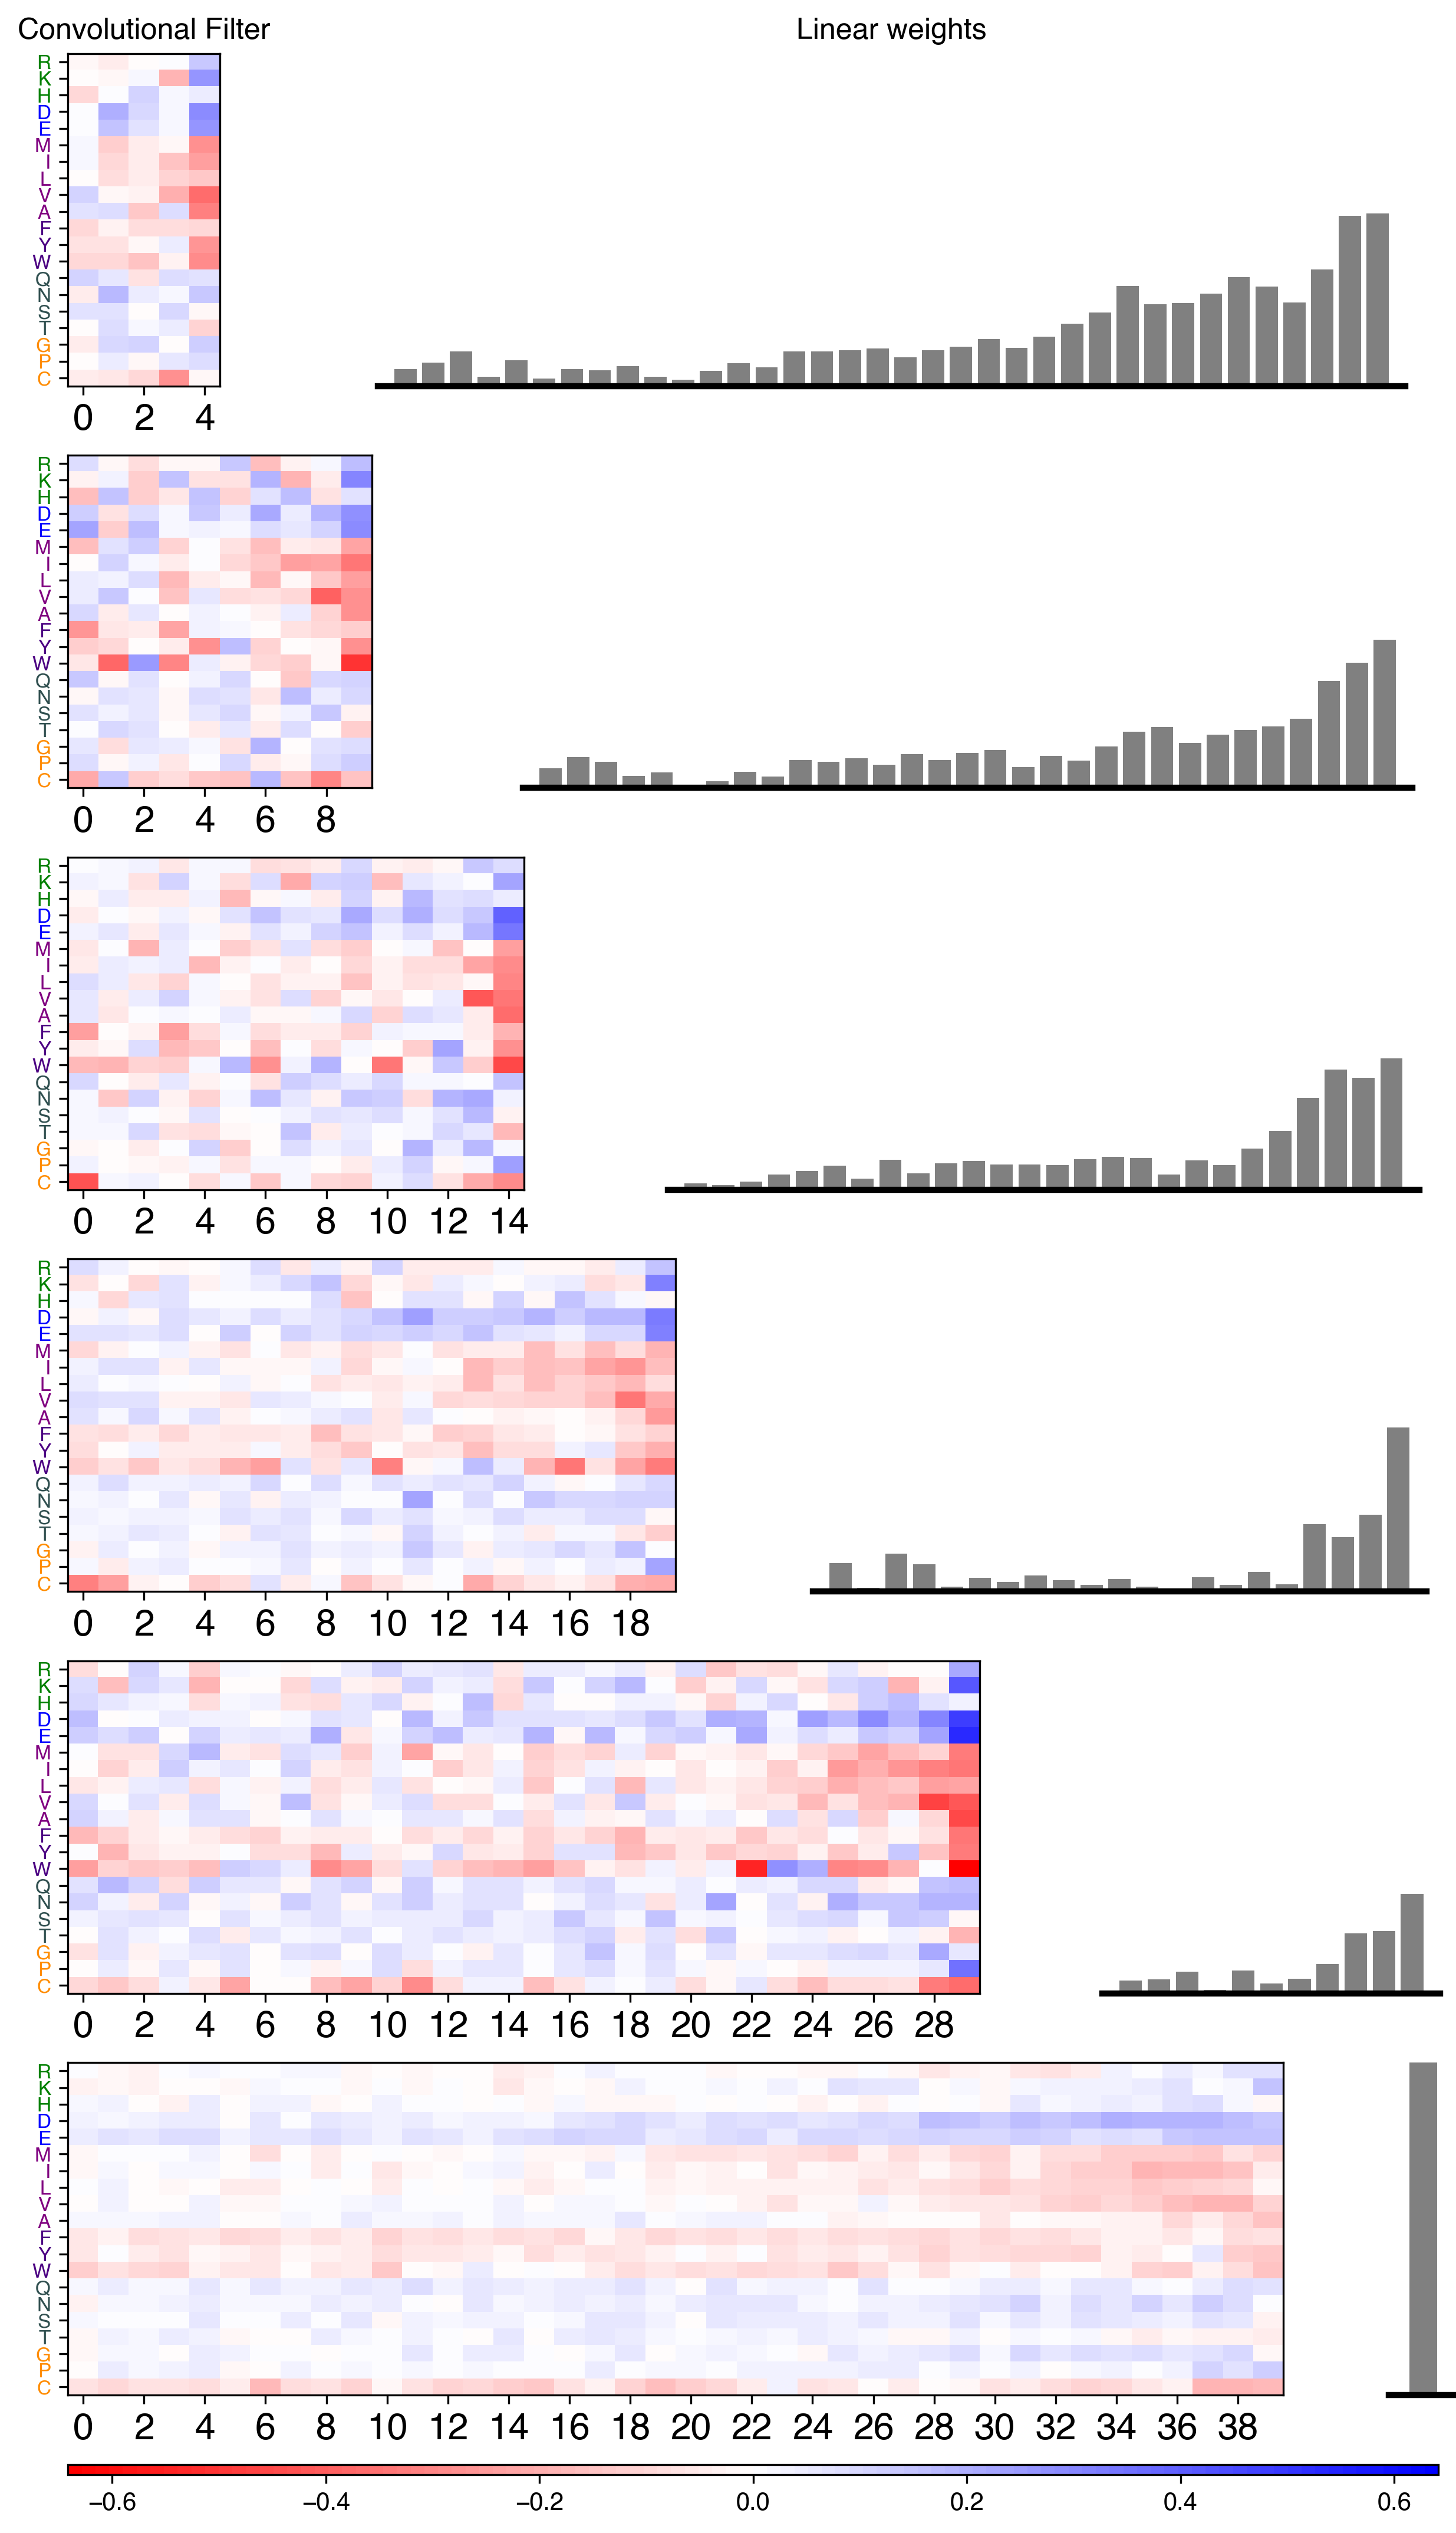

In [28]:
models = [model_5, model_10, model_15, model_20, model_30, model_40]
kernel_sizes = [5, 10, 15, 20, 30, 40]

make_multi_filter_plot_best(models, kernel_sizes)
plt.savefig("figures/simple_abund_best_supp_filter_sizes.pdf", format='pdf', bbox_inches='tight')


# Best models, Activity

In [29]:
best_act = data_simple_act.sort_values("sum_rank", ascending=True).drop_duplicates(" kernel_size", keep="first")

size = (1,40,20)
import torch 

def load_model(name, k):
    model = ADModel_act(size, k)
    model.load_state_dict(torch.load(f"{name}.pth"))
    return model


for index in best_act.index:
    K = best_act.loc[index, " kernel_size"]
    name = best_act.loc[index, "model_name"].removeprefix("../../")
    # ak = int(data_simple_act.loc[index, "abund_kernel_size"])
    if K == 5:
        model_5 = load_model(name, K)
    elif K == 10:
        model_10 = load_model(name, K)
    elif K == 15:
        model_15 = load_model(name, K)
    elif K == 20:
        model_20 = load_model(name, K)
    elif K == 30:
        model_30 = load_model(name, K)
    elif K == 40:
        model_40 = load_model(name, K)


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


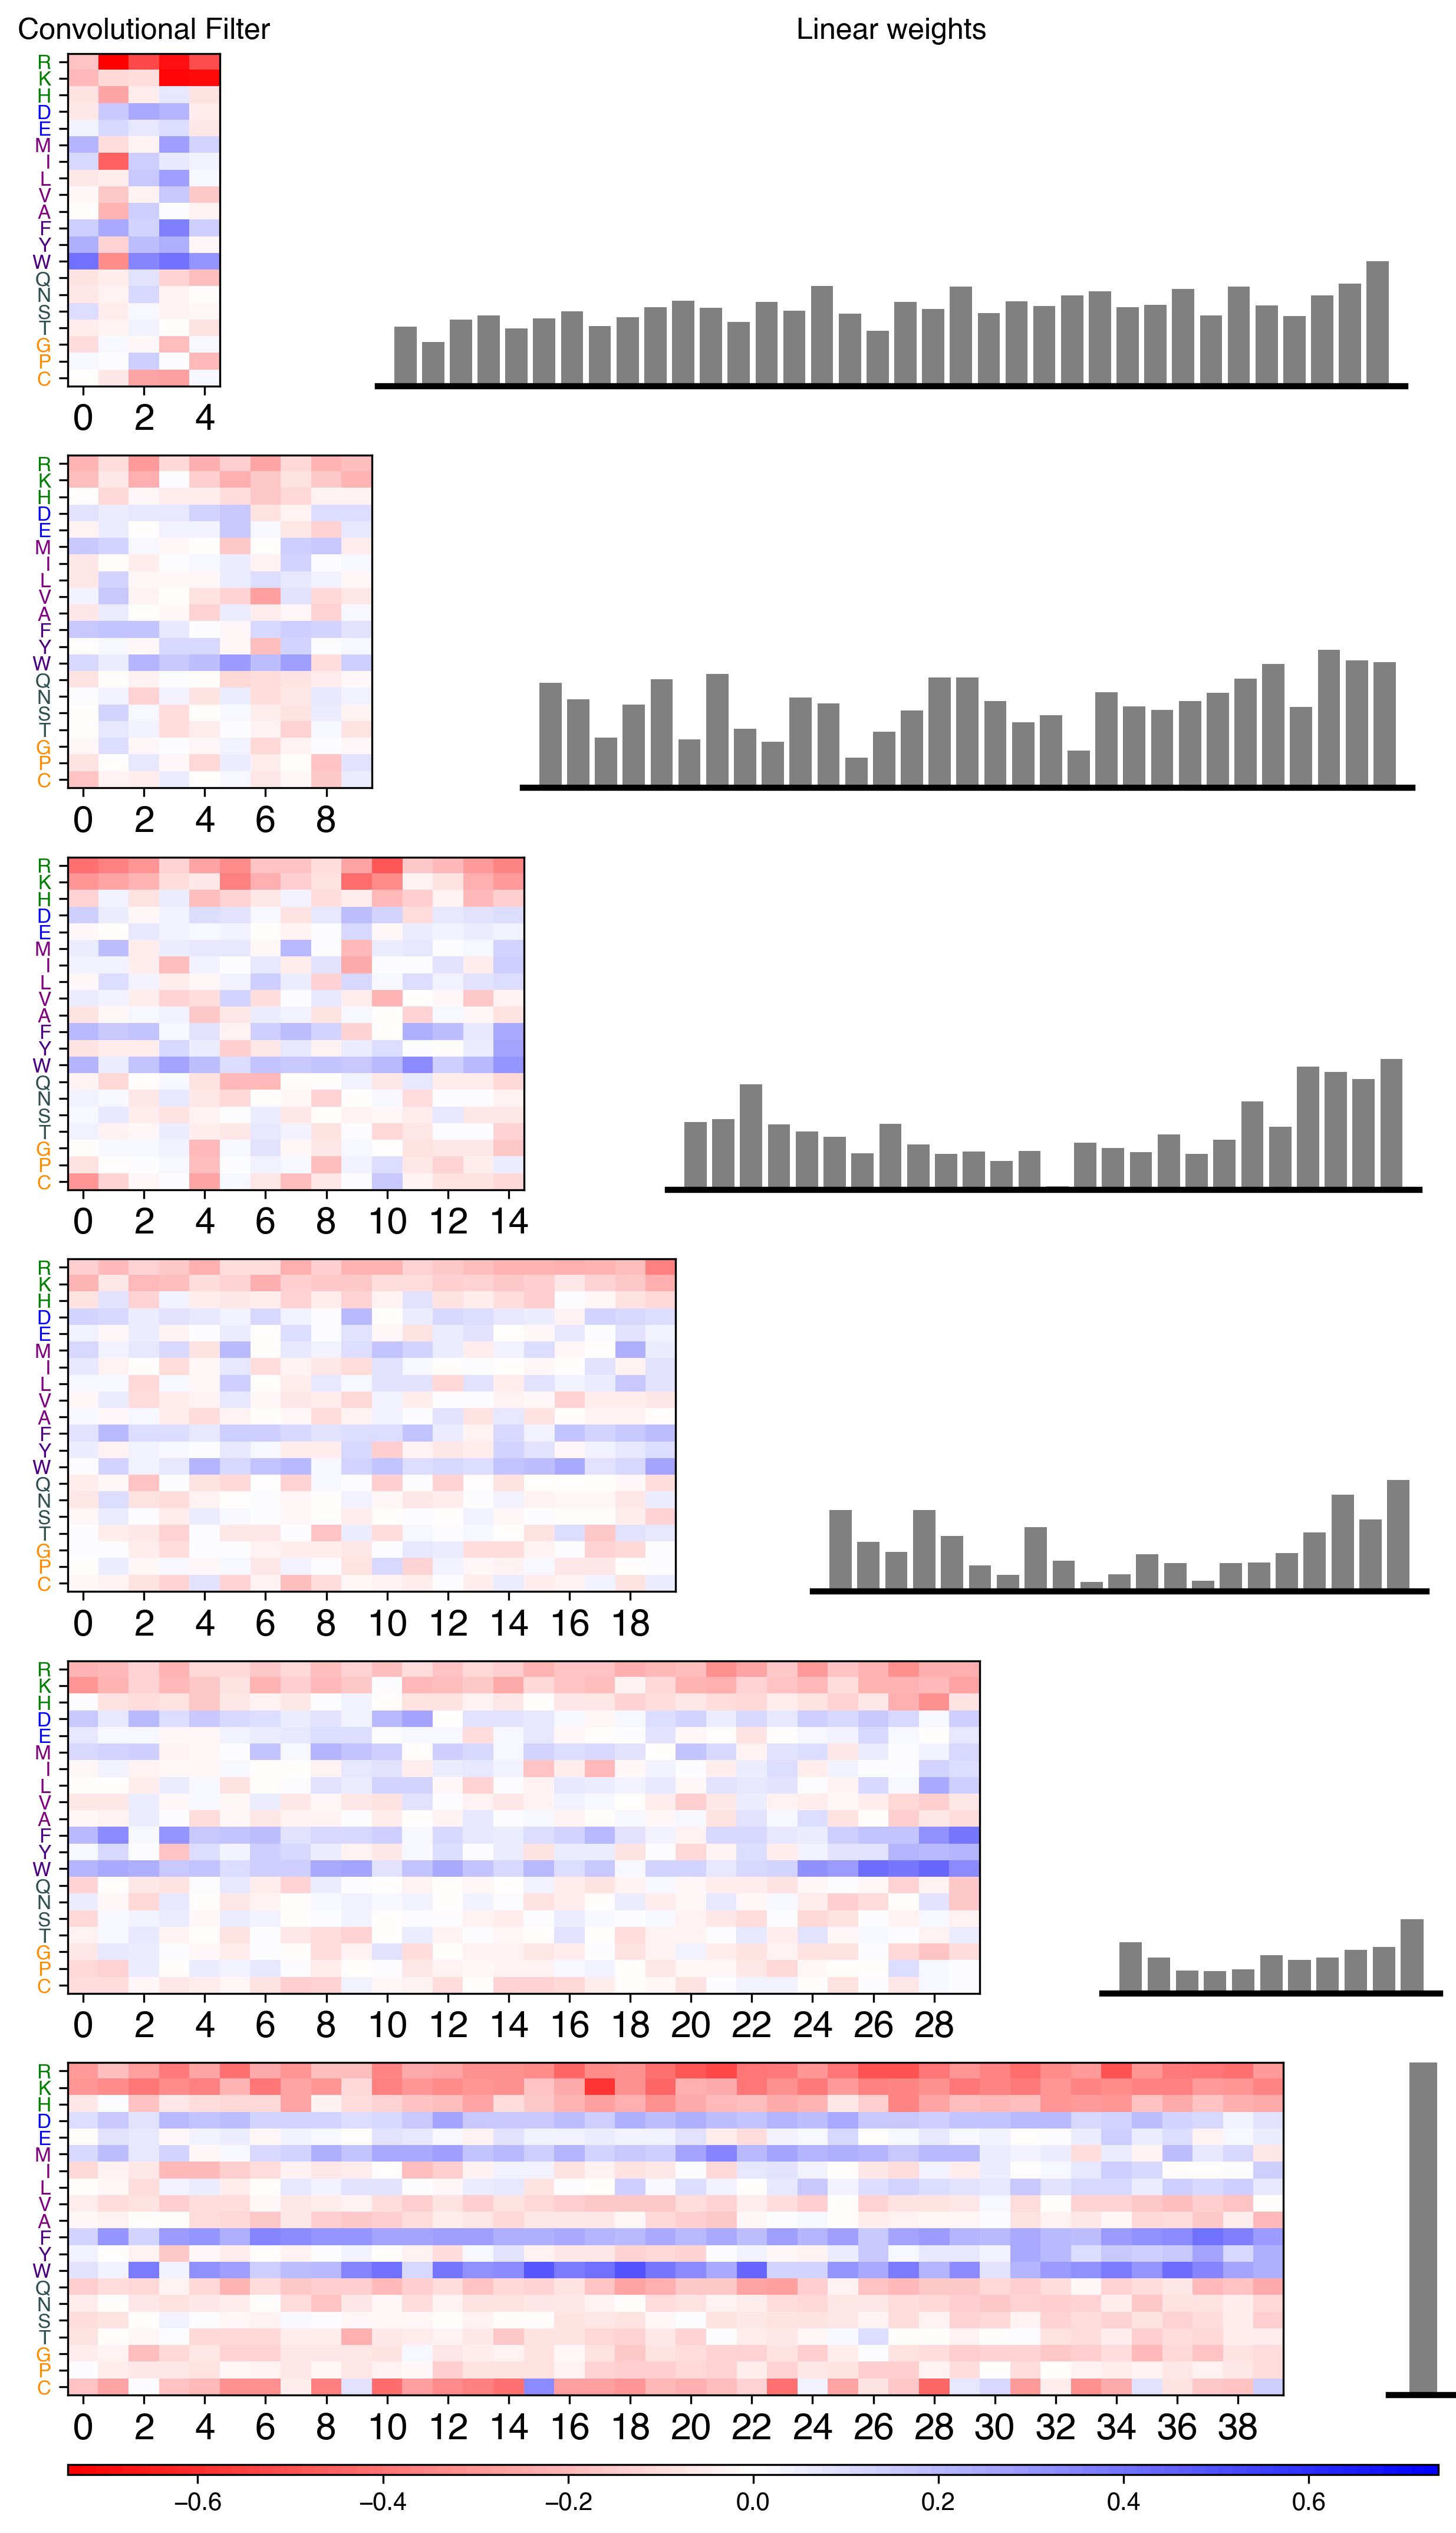

In [30]:
models = [model_5, model_10, model_15, model_20, model_30, model_40]
kernel_sizes = [5, 10, 15, 20, 30, 40]

make_multi_filter_plot_best(models, kernel_sizes)
plt.savefig("figures/simple_best_supp_act_filter_sizes.pdf", format='pdf', bbox_inches='tight')


# Best performing model - two state

In [31]:
best_two_state = data_two_state.sort_values("sum_rank", ascending=True).drop_duplicates("kernel_size", keep="first")

size = (1,40,20)
import torch 

def load_model(name, k, ak):
    model = ADModel_two_state_abund(size, "Hill", k, relu=False, abund_k=ak)
    model.load_state_dict(torch.load(f"{name}.pth"))
    return model


for index in best_two_state.index:
    K = best_two_state.loc[index, "kernel_size"]
    name = best_two_state.loc[index, "model_name"].removeprefix("../../")
    ak = int(best_two_state.loc[index, "abund_kernel_size"])
    if K == 5:
        model_5 = load_model(name, K, ak)
    elif K == 10:
        model_10 = load_model(name, K, ak)
    elif K == 15:
        model_15 = load_model(name, K, ak)
    elif K == 20:
        model_20 = load_model(name, K, ak)
    elif K == 30:
        model_30 = load_model(name, K, ak)
    elif K == 40:
        model_40 = load_model(name, K, ak)


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


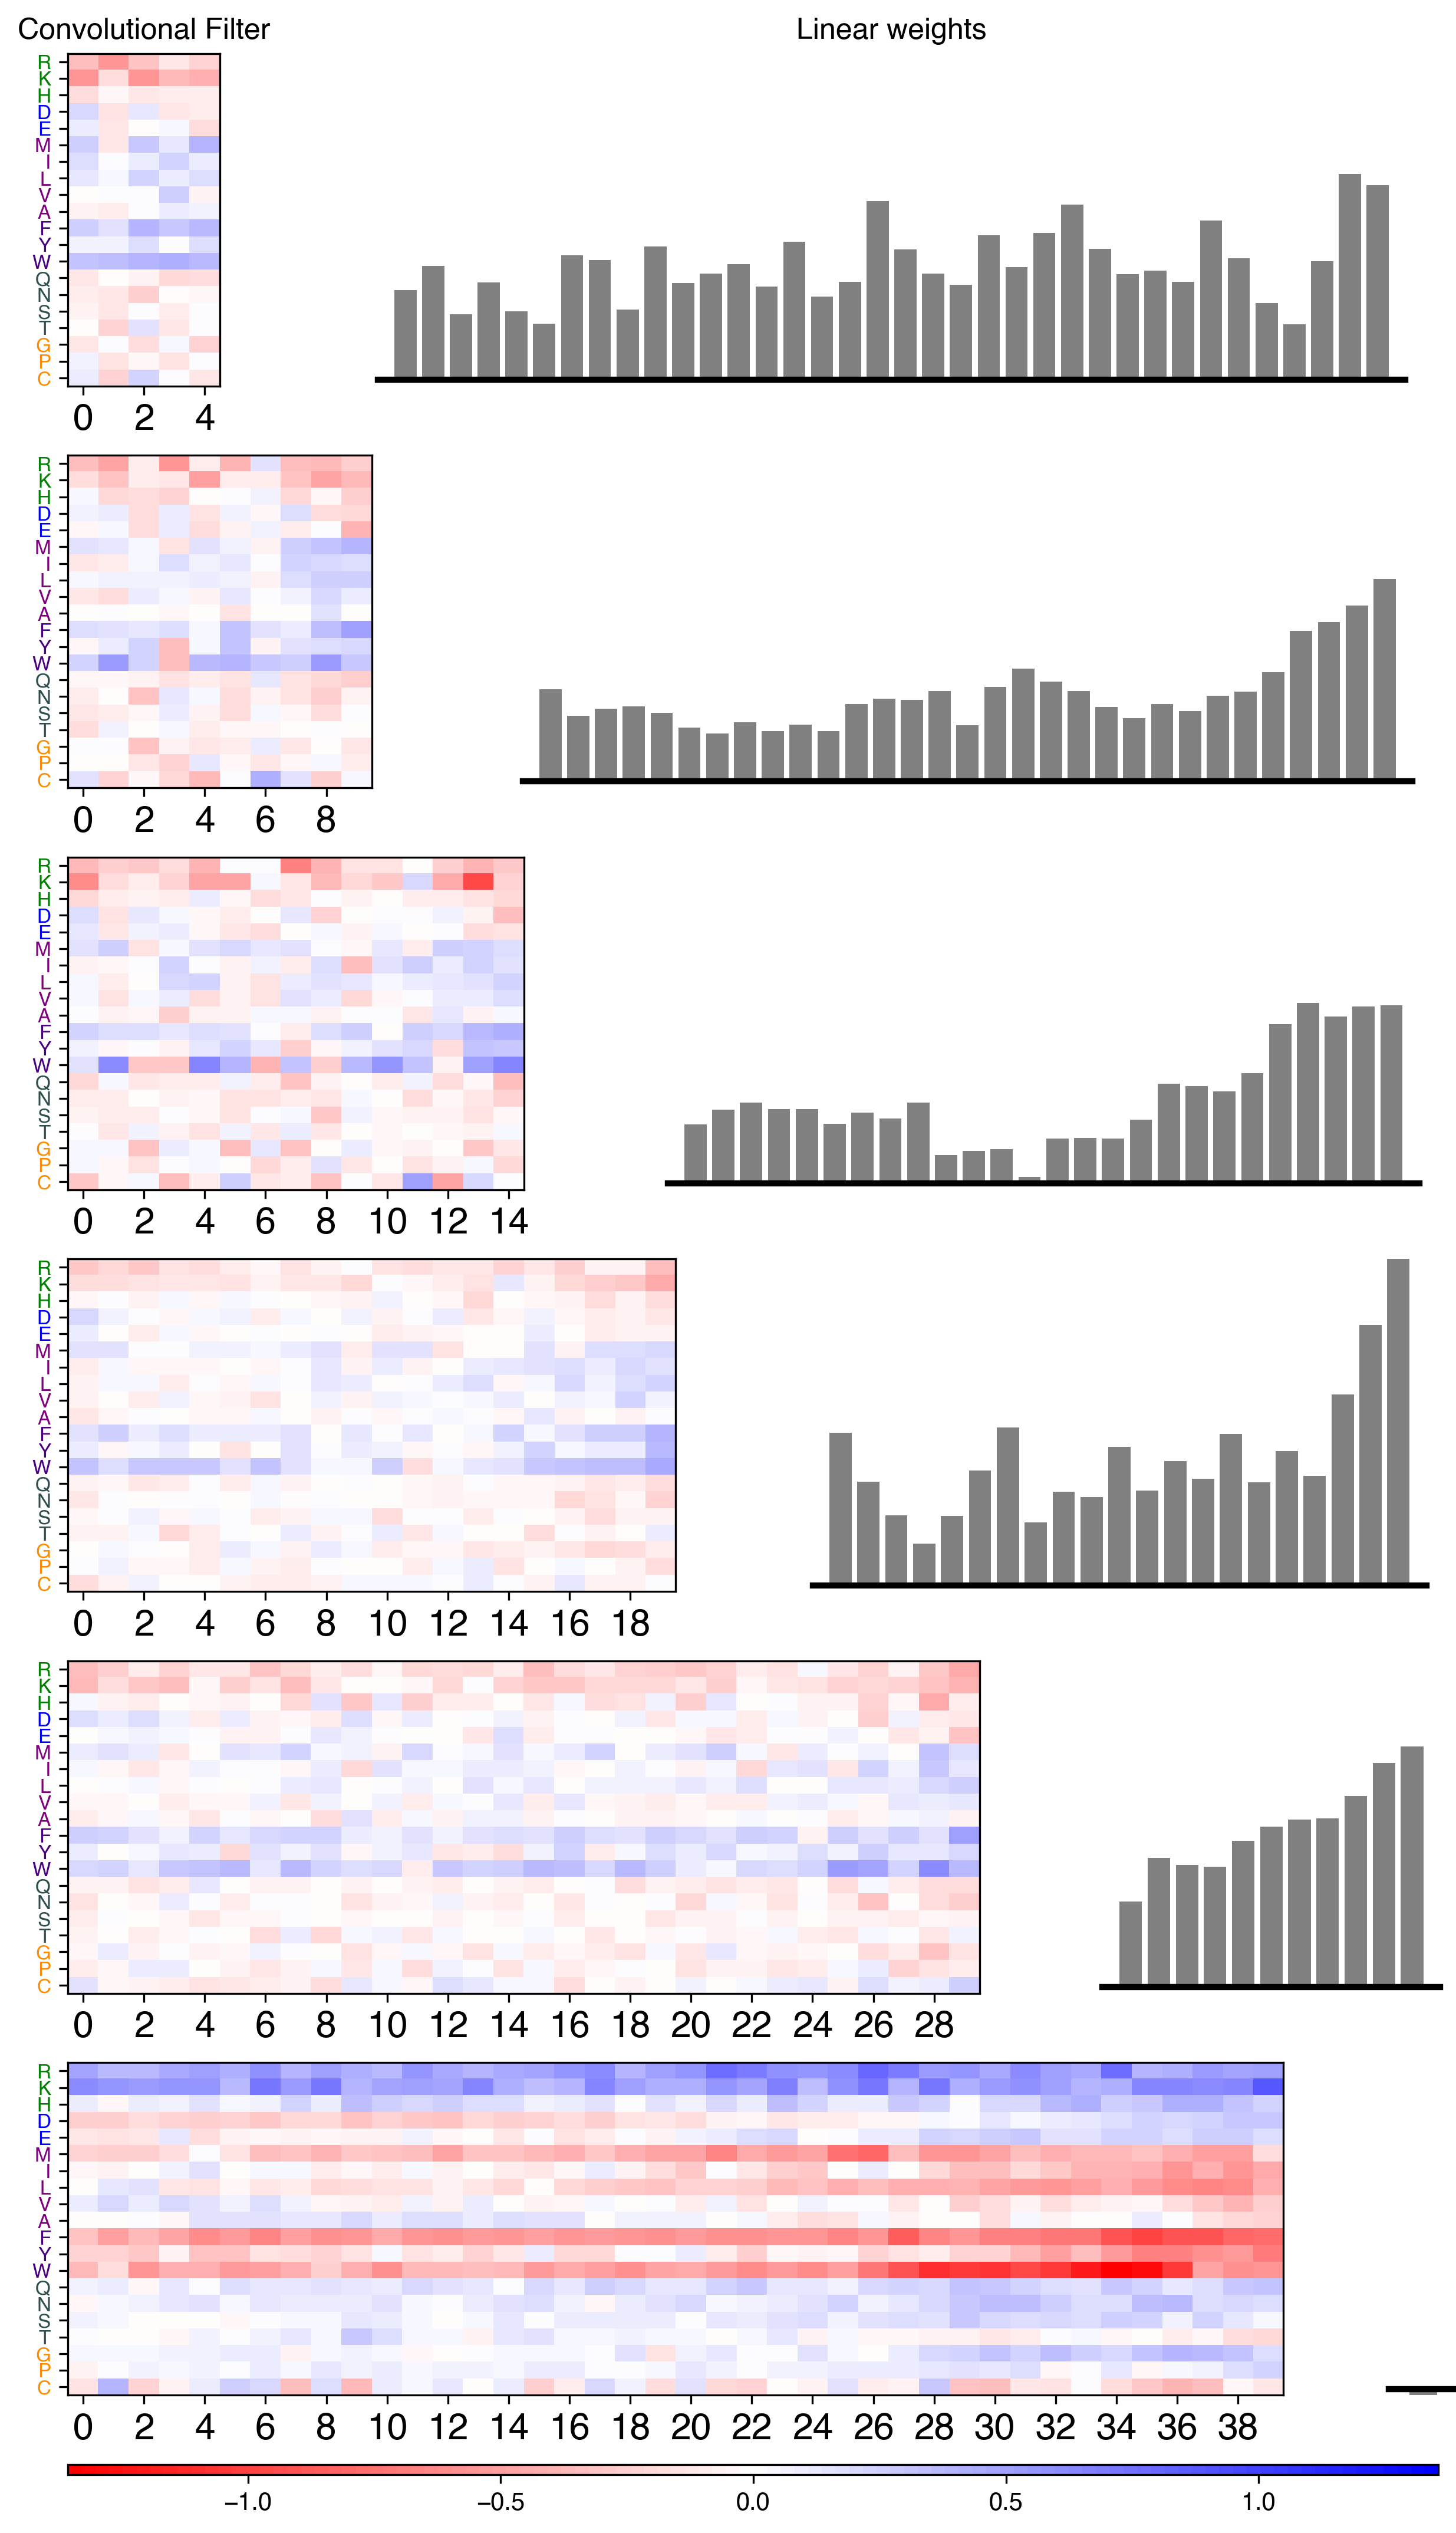

In [32]:
models = [model_5, model_10, model_15, model_20, model_30, model_40]
make_multi_filter_plot_best(models, kernel_sizes)

plt.savefig("figures/two_state_best_supp_filter_sizes.pdf", format='pdf', bbox_inches='tight')


# Best models - three state

In [38]:
best_three_state = data_three_state.sort_values("sum_rank", ascending=True).drop_duplicates("kernel_size", keep="first")

size = (1,40,20)
import torch 

def load_model(name, k, ak):
    model = ADModel_three_state_abund(size, "Hill", k, relu=False, abund_k=ak)
    model.load_state_dict(torch.load(f"{name}.pth"))
    return model


for index in best_three_state.index:
    K = best_three_state.loc[index, "kernel_size"]
    name = best_three_state.loc[index, "model_name"].removeprefix("../../")
    ak = int(best_three_state.loc[index, "abund_kernel_size"])

    if K == 5:
        model_5 = load_model(name, K, ak)
    elif K == 10:
        model_10 = load_model(name, K, ak)
    elif K == 15:
        model_15 = load_model(name, K, ak)
    elif K == 20:
        model_20 = load_model(name, K, ak)
    elif K == 30:
        model_30 = load_model(name, K, ak)
    elif K == 40:
        model_40 = load_model(name, K, ak)


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


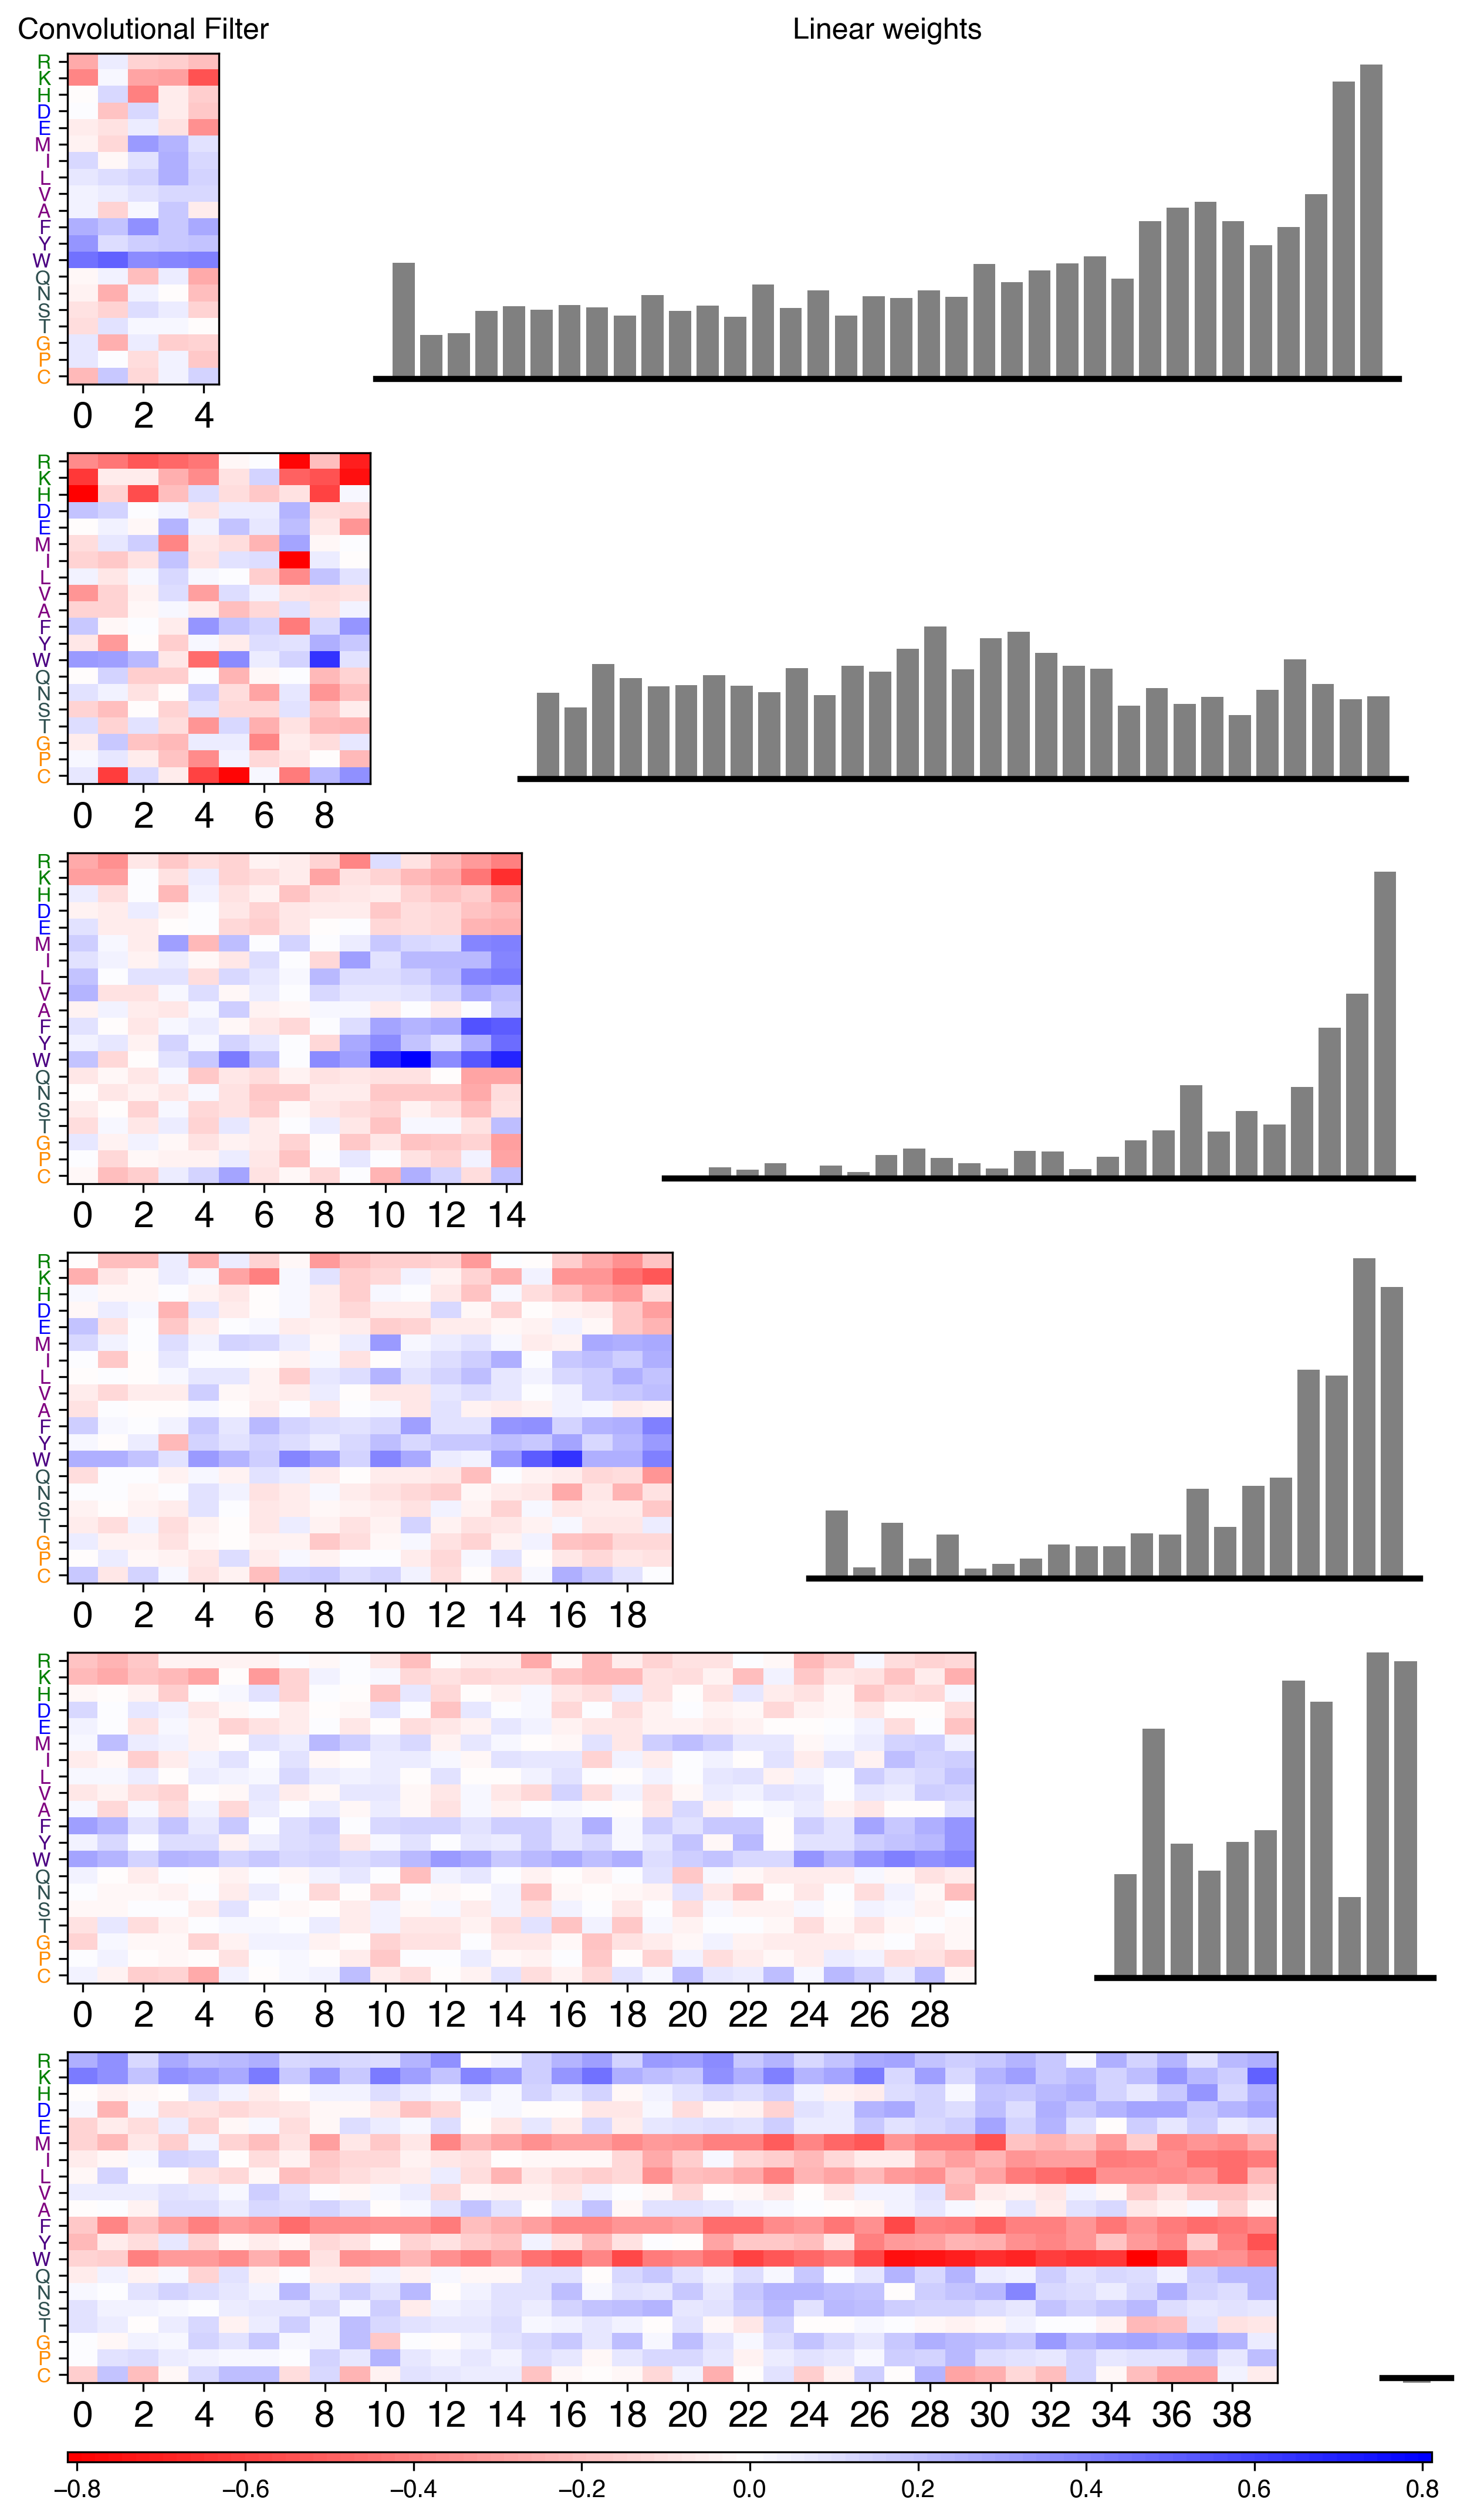

In [39]:
models = [model_5, model_10, model_15, model_20, model_30, model_40]
make_multi_filter_plot_best(models, kernel_sizes)

plt.savefig("figures/three_state_K1_best_supp_filter_sizes.pdf", format='pdf', bbox_inches='tight')


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


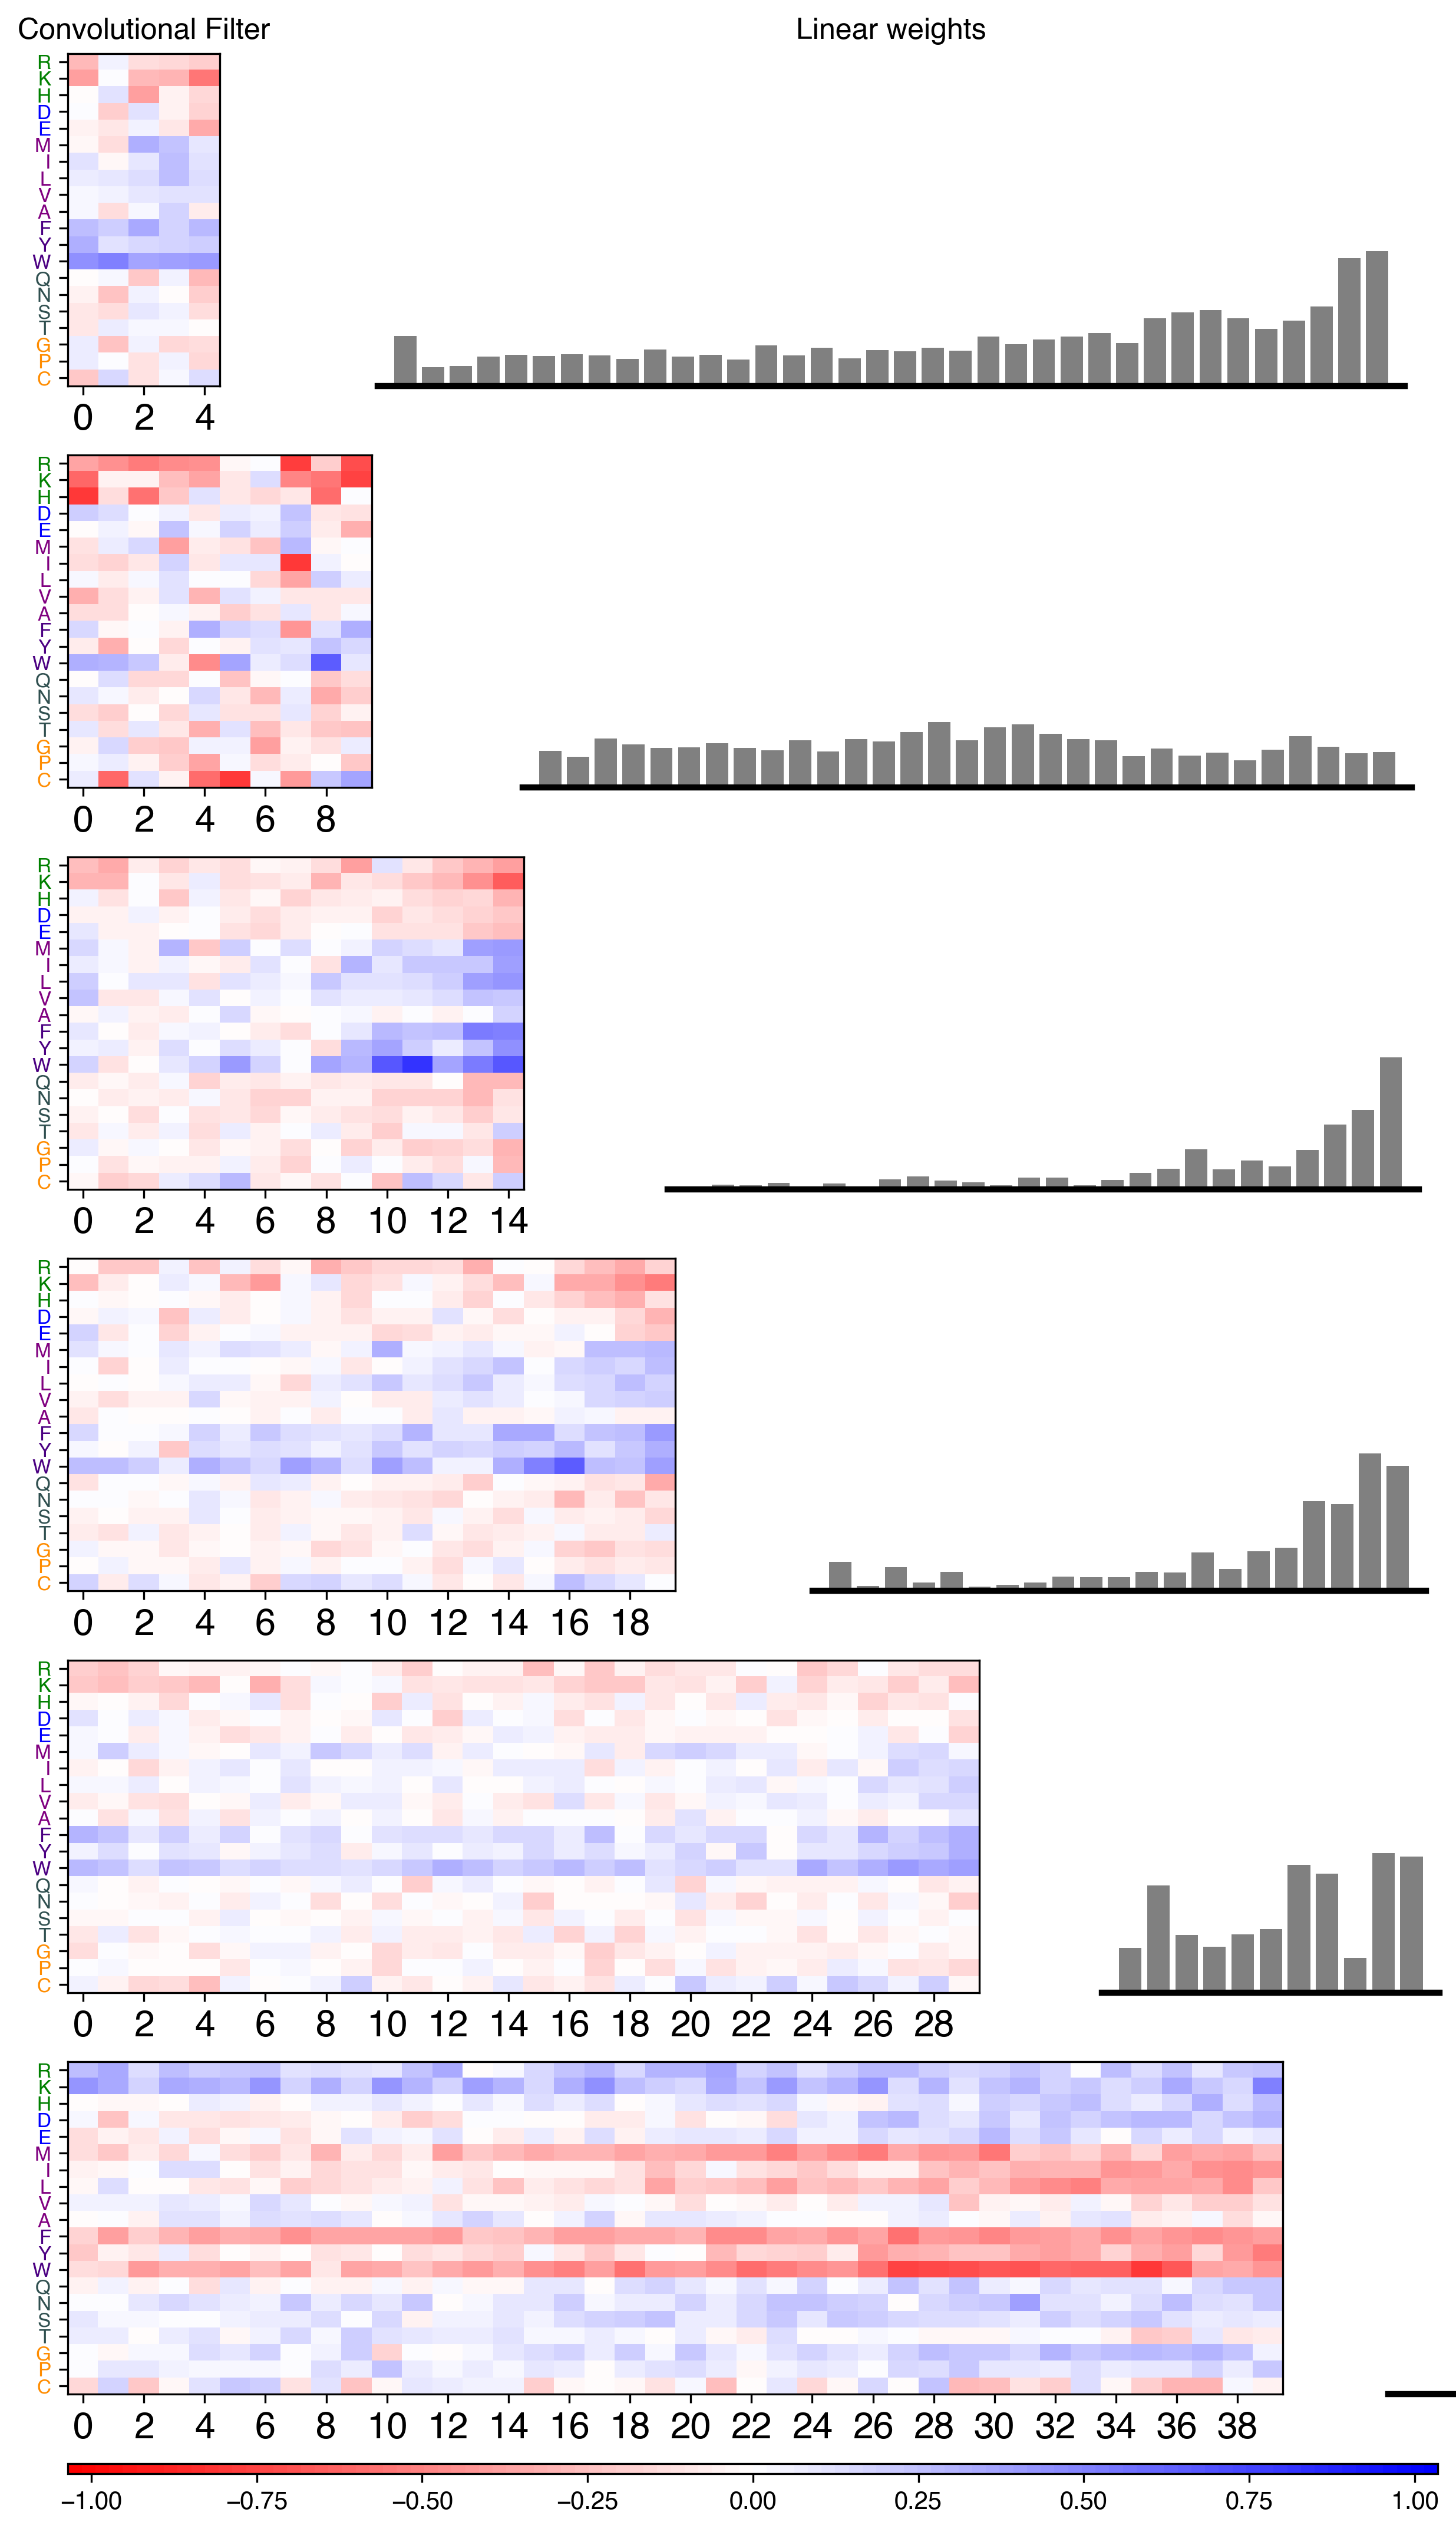

In [40]:
models = [model_5, model_10, model_15, model_20, model_30, model_40]
make_multi_filter_plot_best(models, kernel_sizes, layer_num=2)

plt.savefig("figures/three_state_K2_best_supp_filter_sizes.pdf", format='pdf', bbox_inches='tight')


# Unused functions

In [ ]:
# def make_mean_plots(conv_weights, kernel_size, filter_type=""):
#     """
#     Takes an array of convolutional weights that are the same size and plots
#     the mean of the array as a heatmap

#     Parameters
#     ----------
#     conv_weights : 
#     """
#     stacked_arrays = np.stack(conv_weights, axis=0)

#     mean_array = np.mean(stacked_arrays, axis=0)

#     lim1 = max([abs(w) for w in mean_array.flatten()])


#     fig, axs = plt.subplots(1,1, figsize=(5,5))
#     ax1 = axs

#     im1 = ax1.imshow(mean_array.T, cmap=custom_cmap, aspect='auto',vmin=-lim1,vmax=lim1)
#     ax1.set_yticks(range(20), amino_acids)  # Label x-axis with column names
#     ax1.set_xticks(np.arange(kernel_size, step=1))

#     for ytic in ax1.get_yticklabels():
#         if ytic.get_text() in colors.keys(): 
#             ytic.set_color(colors[ytic.get_text()])
#     # fig.colorbar(im)
#     ax1.tick_params(axis='both', which='major', labelsize=8) 

#     ax1.set_title(f"Mean of {filter_type} Convolutional Filters", fontsize=12)

#     fig.colorbar(im1,ax=ax1, orientation='horizontal')
